# Diagnosing Biased Inference with Divergences

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from collections import defaultdict

print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.9.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
SEED = [20100420, 20134234, 8972, 4466872]

This notebook is a PyMC3 port of [Michael Betancourt's post on ms-stan](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html). For detailed explanation of the underlying mechanism please check [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) and Betancourt's [excellent paper](https://arxiv.org/abs/1701.02434).

Bayesian statistics is all about building a model and estimating the parameters in that model. However, a naive or direct parameterization of our probability model can sometimes be ineffective, you can check out [Thomas Wiecki's blog post](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) on the same issue in PyMC3. Suboptimal parameterization often leads to slow sampling, and more problematic, biased MCMC estimators. 

More formally, as explained in [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html):

Markov chain Monte Carlo (MCMC) approximates expectations with respect to a given target distribution, 

$$ \mathbb{E}{\pi} [ f ] = \int \mathrm{d}q \, \pi (q) \, f(q)$$ 

using the states of a Markov chain, ${q{0}, \ldots, q_{N} }$, 

$$ \mathbb{E}{\pi} [ f ] \approx \hat{f}{N} = \frac{1}{N + 1} \sum_{n = 0}^{N} f(q_{n}) $$  

These estimators, however, are guaranteed to be accurate only asymptotically as the chain grows to be infinitely long, 

$$ \lim_{N \rightarrow \infty} \hat{f}{N} = \mathbb{E}{\pi} [ f ]$$  

To be useful in applied analyses, we need MCMC estimators to converge to the true expectation values sufficiently quickly that they are reasonably accurate before we exhaust our finite computational resources. This fast convergence requires strong ergodicity conditions to hold, in particular geometric ergodicity between a Markov transition and a target distribution. Geometric ergodicity is usually the necessary condition for MCMC estimators to follow a central limit theorem, which ensures not only that they are unbiased even after only a finite number of iterations but also that we can empirically quantify their precision using the MCMC standard error.

Unfortunately, proving geometric ergodicity is infeasible for any nontrivial problem. Instead we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved MCMC estimators. For a general Markov transition and target distribution, the best known diagnostic is the split $\hat{R}$ statistic over an ensemble of Markov chains initialized from diffuse points in parameter space; to do any better we need to exploit the particular structure of a given transition or target distribution.
 
Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore.

In this notebook we aim to identify divergences and the underlying pathologies in `PyMC3`.

## The Eight Schools Model

The hierarchical model of the Eight Schools dataset (Rubin 1981) as seen in `Stan`:

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\theta_{n} \sim \mathcal{N}(\mu, \tau)$$
$$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$$  

where $n \in \{1, \ldots, 8 \}$ and the $\{ y_{n}, \sigma_{n} \}$ are given as data.  

Inferring the hierarchical hyperparameters, $\mu$ and $\sigma$, together with the group-level parameters, $\theta_{1}, \ldots, \theta_{8}$, allows the model to pool data across the groups and reduce their posterior variance. Unfortunately, the direct *centered* parameterization also squeezes the posterior distribution into a particularly challenging geometry that obstructs geometric ergodicity and hence biases MCMC estimation.

In [3]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

## A Centered Eight Schools Implementation  

`Stan` model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
```
Similarly, we can easily implement it in `PyMC3`

In [4]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

Unfortunately, this direct implementation of the model exhibits a pathological geometry that frustrates geometric ergodicity. Even more worrisome, the resulting bias is subtle and may not be obvious upon inspection of the Markov chain alone. To understand this bias, let's consider first a short Markov chain, commonly used when computational expediency is a motivating factor, and only afterwards a longer Markov chain.

### A Dangerously Short Markov Chain

In [5]:
SHORT_SEED = [8972, 20100420]
with Centered_eight:
    short_trace = pm.sample(350, tune=500, chains=2, random_seed=SHORT_SEED)
    short_trace_idata = az.from_pymc3(short_trace)
short_trace_summary = az.summary(short_trace_idata).round(2)
short_trace_summary

Only 350 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 500 tune and 350 draw iterations (1_000 + 700 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044779922802081, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu        4.60  3.27   -1.63    10.13       0.32     0.22     108.0   107.0   
theta[0]  7.12  5.80   -3.78    18.70       0.42     0.30     194.0   194.0   
theta[1]  5.38  5.07   -4.04    15.05       0.33     0.24     242.0   227.0   
theta[2]  4.27  5.59   -6.07    15.51       0.37     0.26     233.0   233.0   
theta[3]  5.03  5.80   -5.40    16.92       0.31     0.29     352.0   195.0   
theta[4]  3.53  4.95   -5.26    13.38       0.41     0.29     147.0   147.0   
theta[5]  4.04  5.04   -5.88    13.89       0.35     0.25     206.0   206.0   
theta[6]  7.02  5.54   -2.86    18.44       0.38     0.27     210.0   210.0   
theta[7]  4.88  5.81   -5.14    16.39       0.38     0.28     238.0   216.0   
tau       4.74  3.23    1.16    10.76       0.46     0.33      49.0    49.0   

          ess_bulk  ess_tail  r_hat  
mu           109.0     218.0   1.01  
theta[0]     178.0     352.0   1.00  
theta[1]     238.0     281.0   1.01  
theta[2]     226.0     352.0   1.00  
theta[3]     336.0     264.0   1.03  
theta[4]     148.0     300.0   1.01  
theta[5]     197.0     409.0   1.02  
theta[6]     205.0     388.0   1.00  
theta[7]     208.0     405.0   1.02  
tau           39.0      49.0   1.05

In the [original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) a single chain of 1200 sample is applied. However, since split $\hat{R}$[[1]](#fn1) is not implemented in `PyMC3` we fit 2 chains with 600 samples each instead.  

The Gelman-Rubin diagnostic $\hat{R}$ values are *relatively* good, although the results for $\tau$ do not look great (heuristically, the PyMC3 project uses 1.03 as a cutoff level). You could try re-running the model with a different seed and see if this still holds.

<span id="fn1">[1] "Split $\hat{R}$" is $\hat{R}$ computed with the first half of a trace against the second.</span>

Moreover, the trace plots all look fine. Indeed the chains seem to be exploring both small and large values reasonably well,



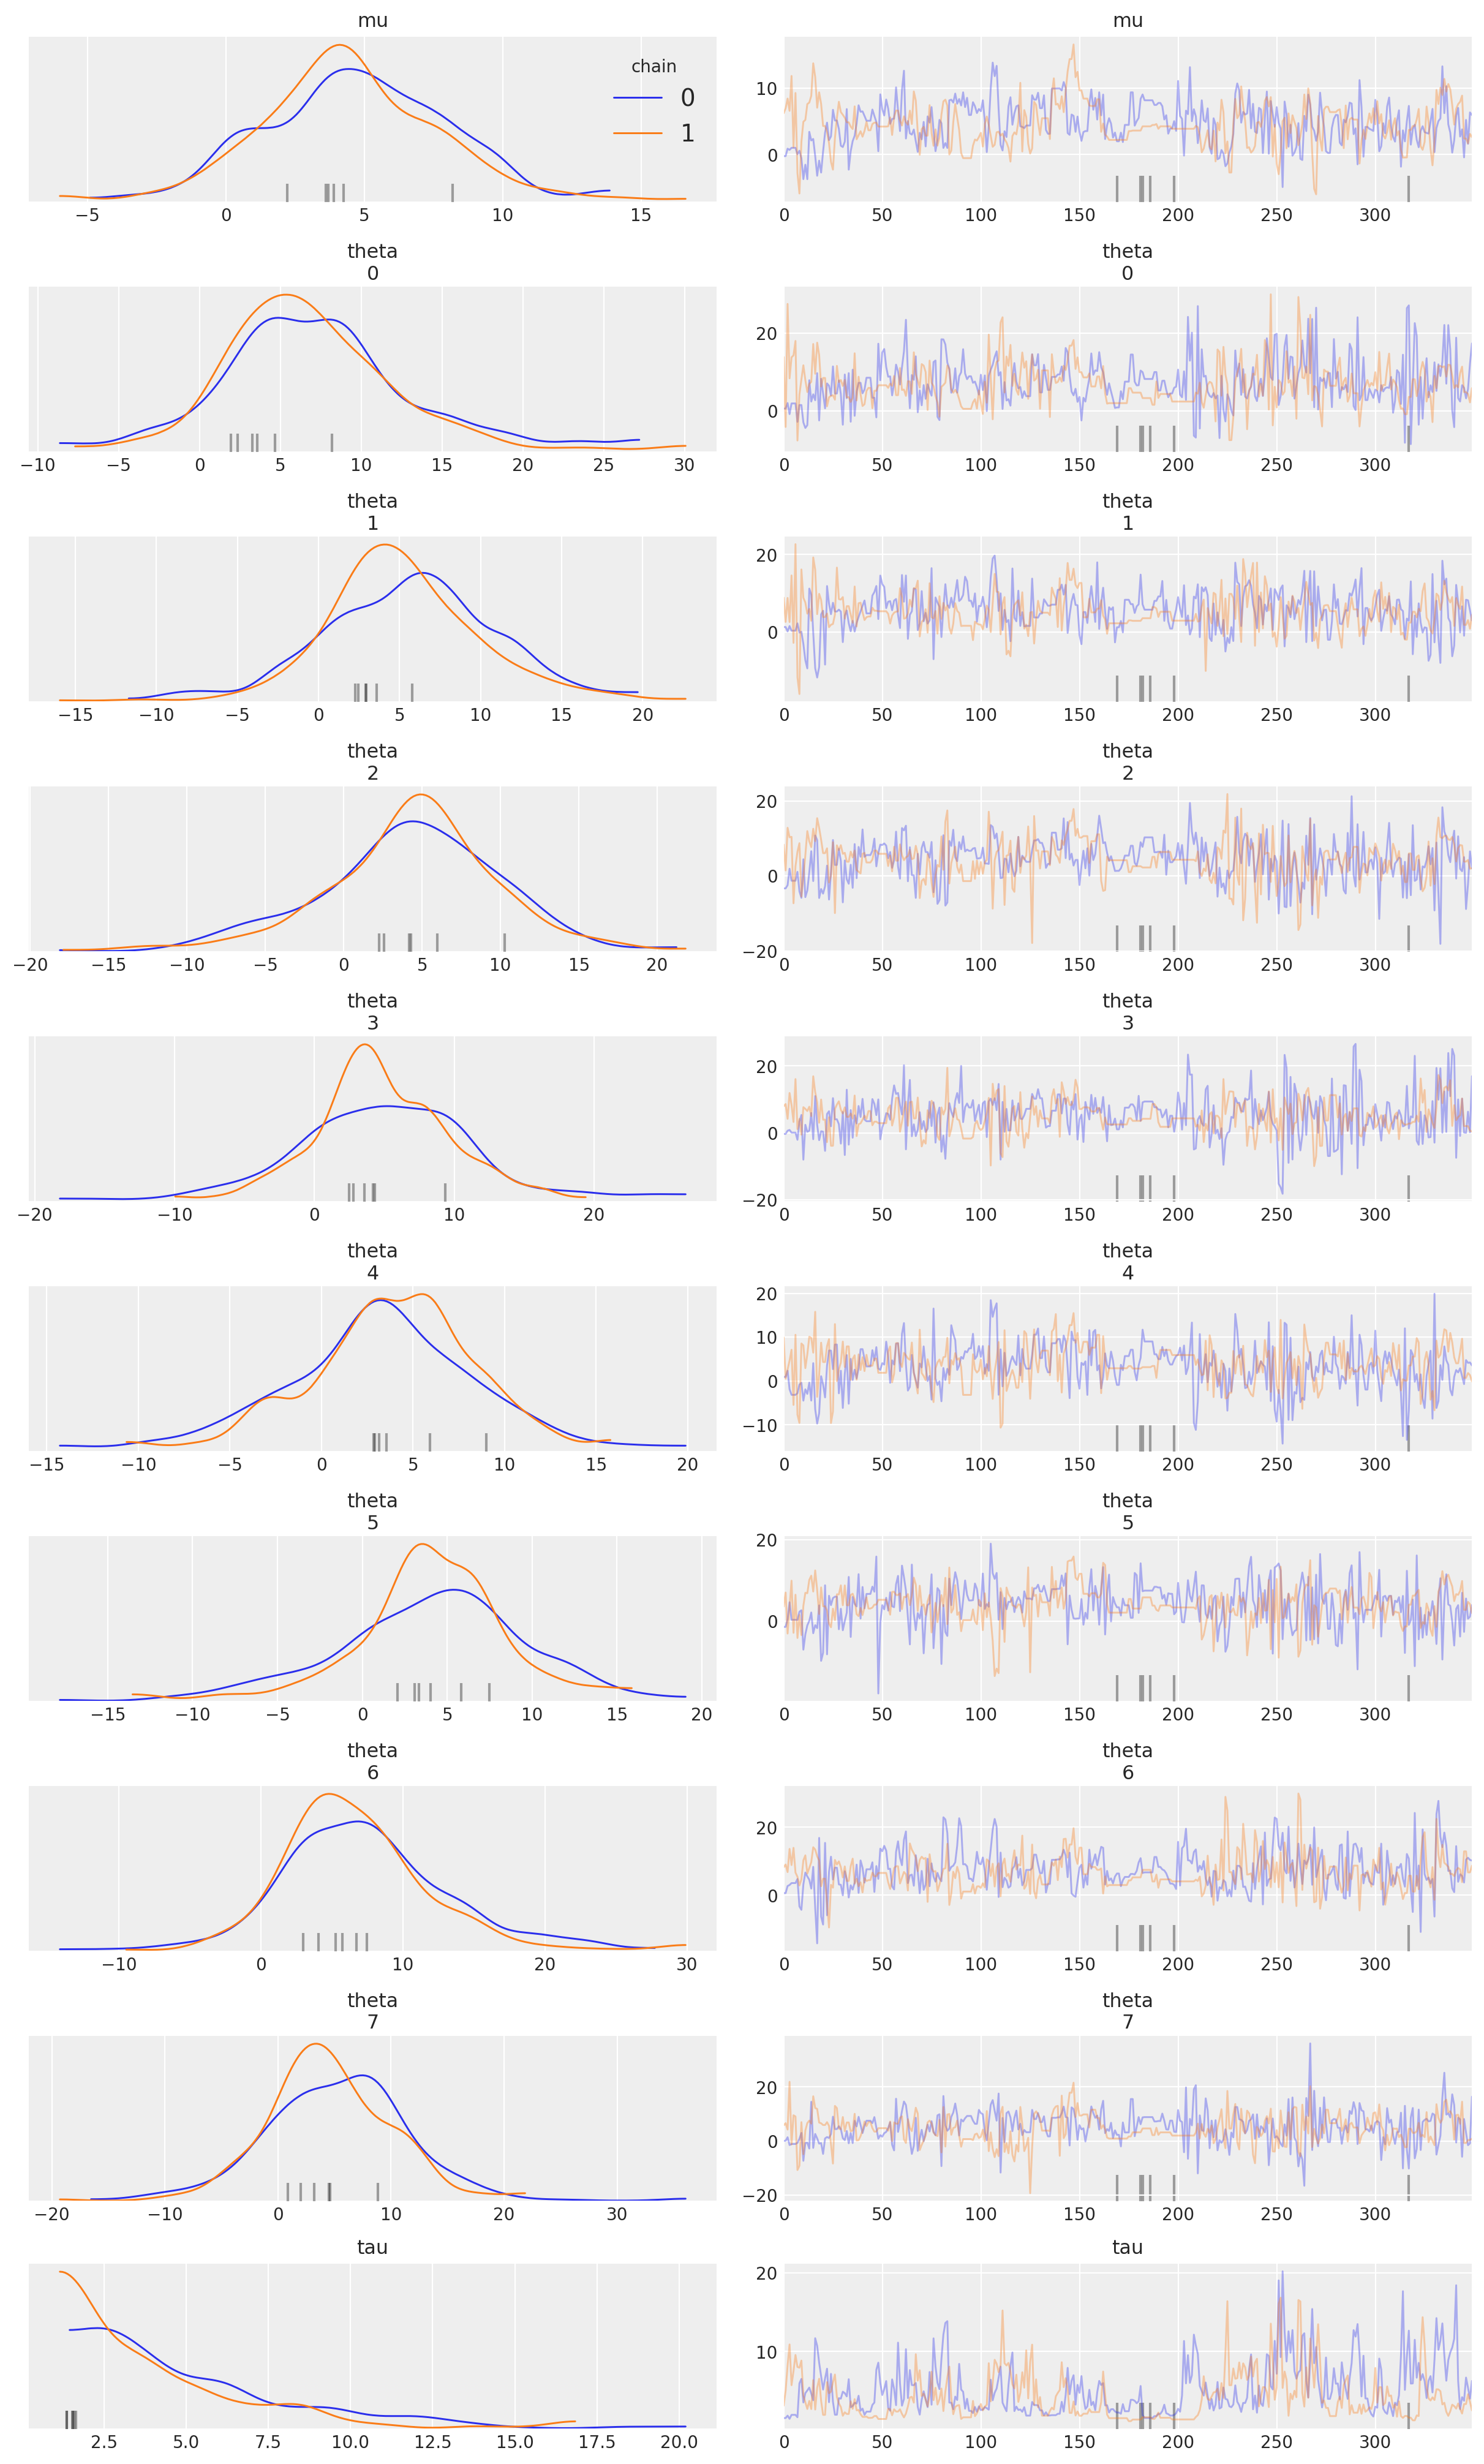

In [6]:
with Centered_eight:
    az.plot_trace(short_trace, legend=True);

However, if we look at the *logarithm* of the hierarchical standard deviation $\tau$, we can start to see the pathology.  Because $\tau$ is constrained to be positive, its logarithm will allow us to better resolve behavior for small values.  You can see that the two chains look quite different, and it looks like chain 1 has gotten stuck.

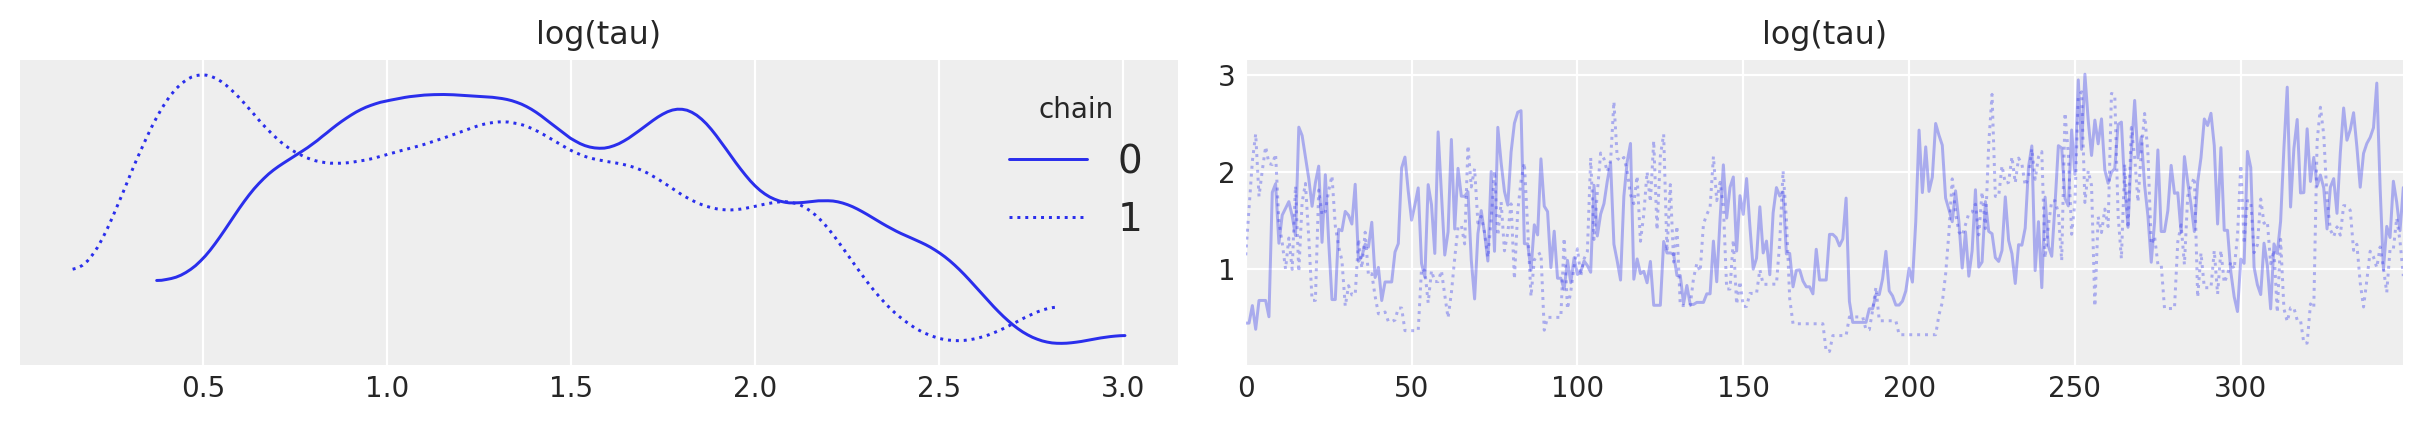

In [7]:
pm.traceplot({"log(tau)": short_trace.get_values(varname='tau_log__', combine=False)}, legend=True);

The resulting estimate for the mean of $log(\tau)$ is strongly biased away from the true value, here shown in grey.  (Note that when we address a multi-chain trace, it is done as if "flattened" by concatenating the chains in chain order.)

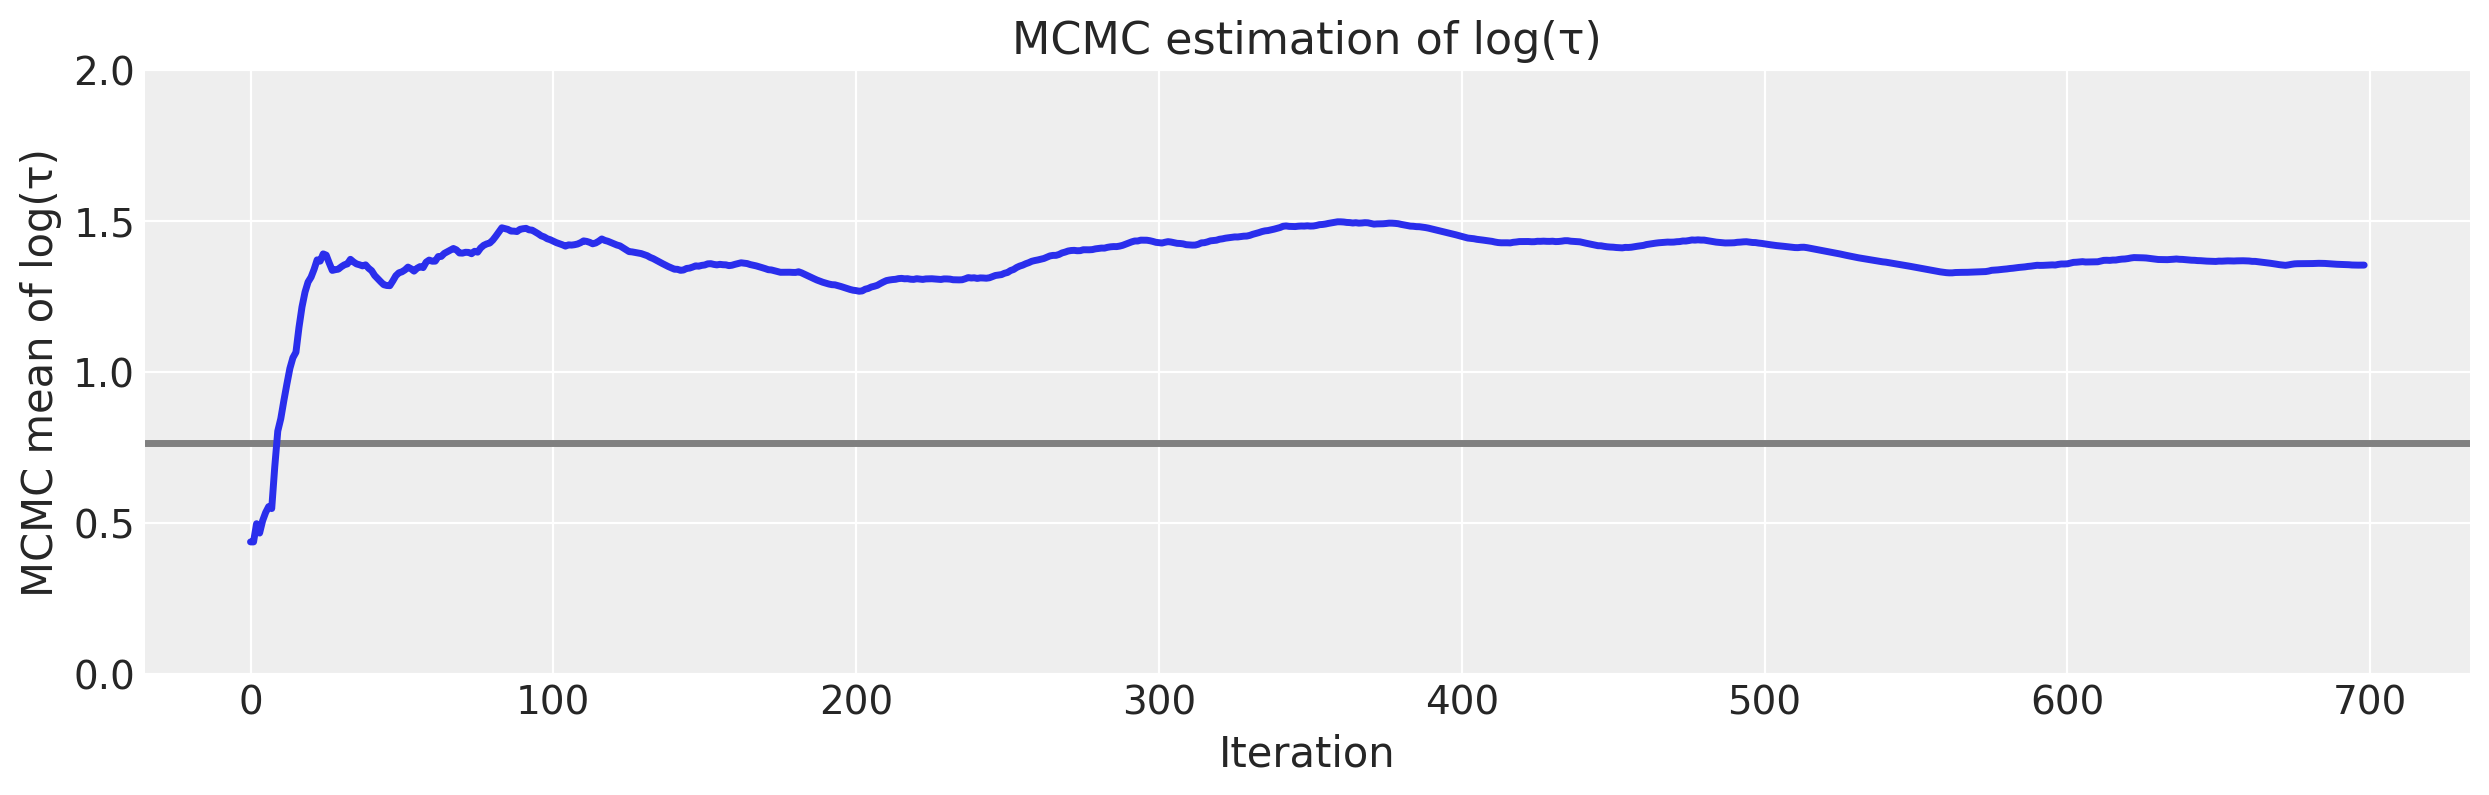

In [8]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(τ)')
plt.title('MCMC estimation of log(τ)');

Hamiltonian Monte Carlo (HMC) brings out these issues by its divergences.

---

**Notes:**

* Because the length of trace is the number of samples *in the last chain* instead of the total number of samples, the divergence percentages were computed incorrectly.  Using *chain* length instead of total number of samples as the interpretation of `len()` is not great, IMO.

---


In [9]:
# display the total number and percentage of divergent
divergent = short_trace['diverging']
print('Number of Divergent iterations: %d' % divergent.nonzero()[0].size)
divperc = (divergent.nonzero()[0].size / divergent.size) * 100
print('Percentage of Divergent iterations: %.1f\n' % divperc)

Number of Divergent iterations: 6
Percentage of Divergent iterations: 0.9



Even with short chains these divergences are able to identity the bias and advise skepticism of any resulting MCMC estimators.

Additionally, because the divergent transitions, here shown in green, tend to be located near the pathologies we can use them to identify the location of the problematic neighborhoods in parameter space.

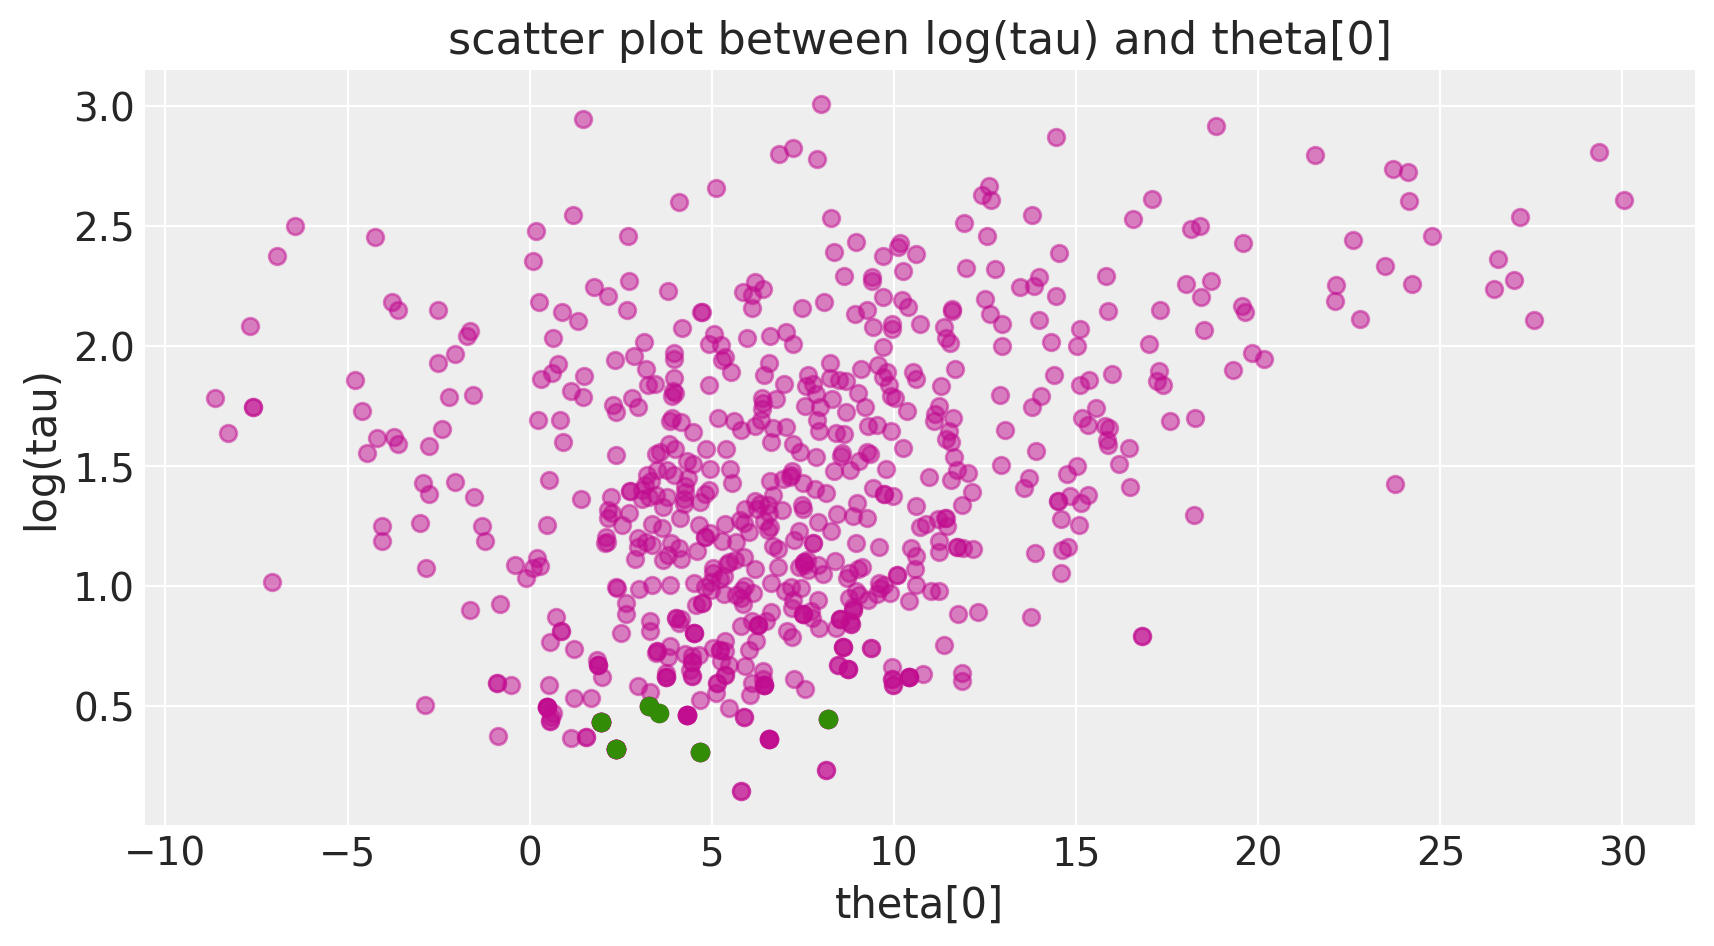

In [10]:
def pairplot_divergence(trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(short_trace);

It is important to point out that the pathological samples from the trace are not necessarily concentrated at the funnel: when a divergence is encountered, the subtree being constructed is rejected and the transition samples uniformly from the existing discrete trajectory. Consequently, divergent samples will not be located exactly in the region of high curvature.

In `pymc3`, we recently implemented a warning system that also saves the information of _where_ the divergence occurs, and hence you can visualize them directly. To be more precise, what we include as the divergence point in the warning is the point where that problematic leapfrog step started. Some could also be because the divergence happens in one of the leapfrog step (which strictly speaking is not a point). But nonetheless, visualizing these should give a closer proximate where the funnel is.

Notice that only the first 100 divergences are stored, so that we don't eat all memory.

In [11]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

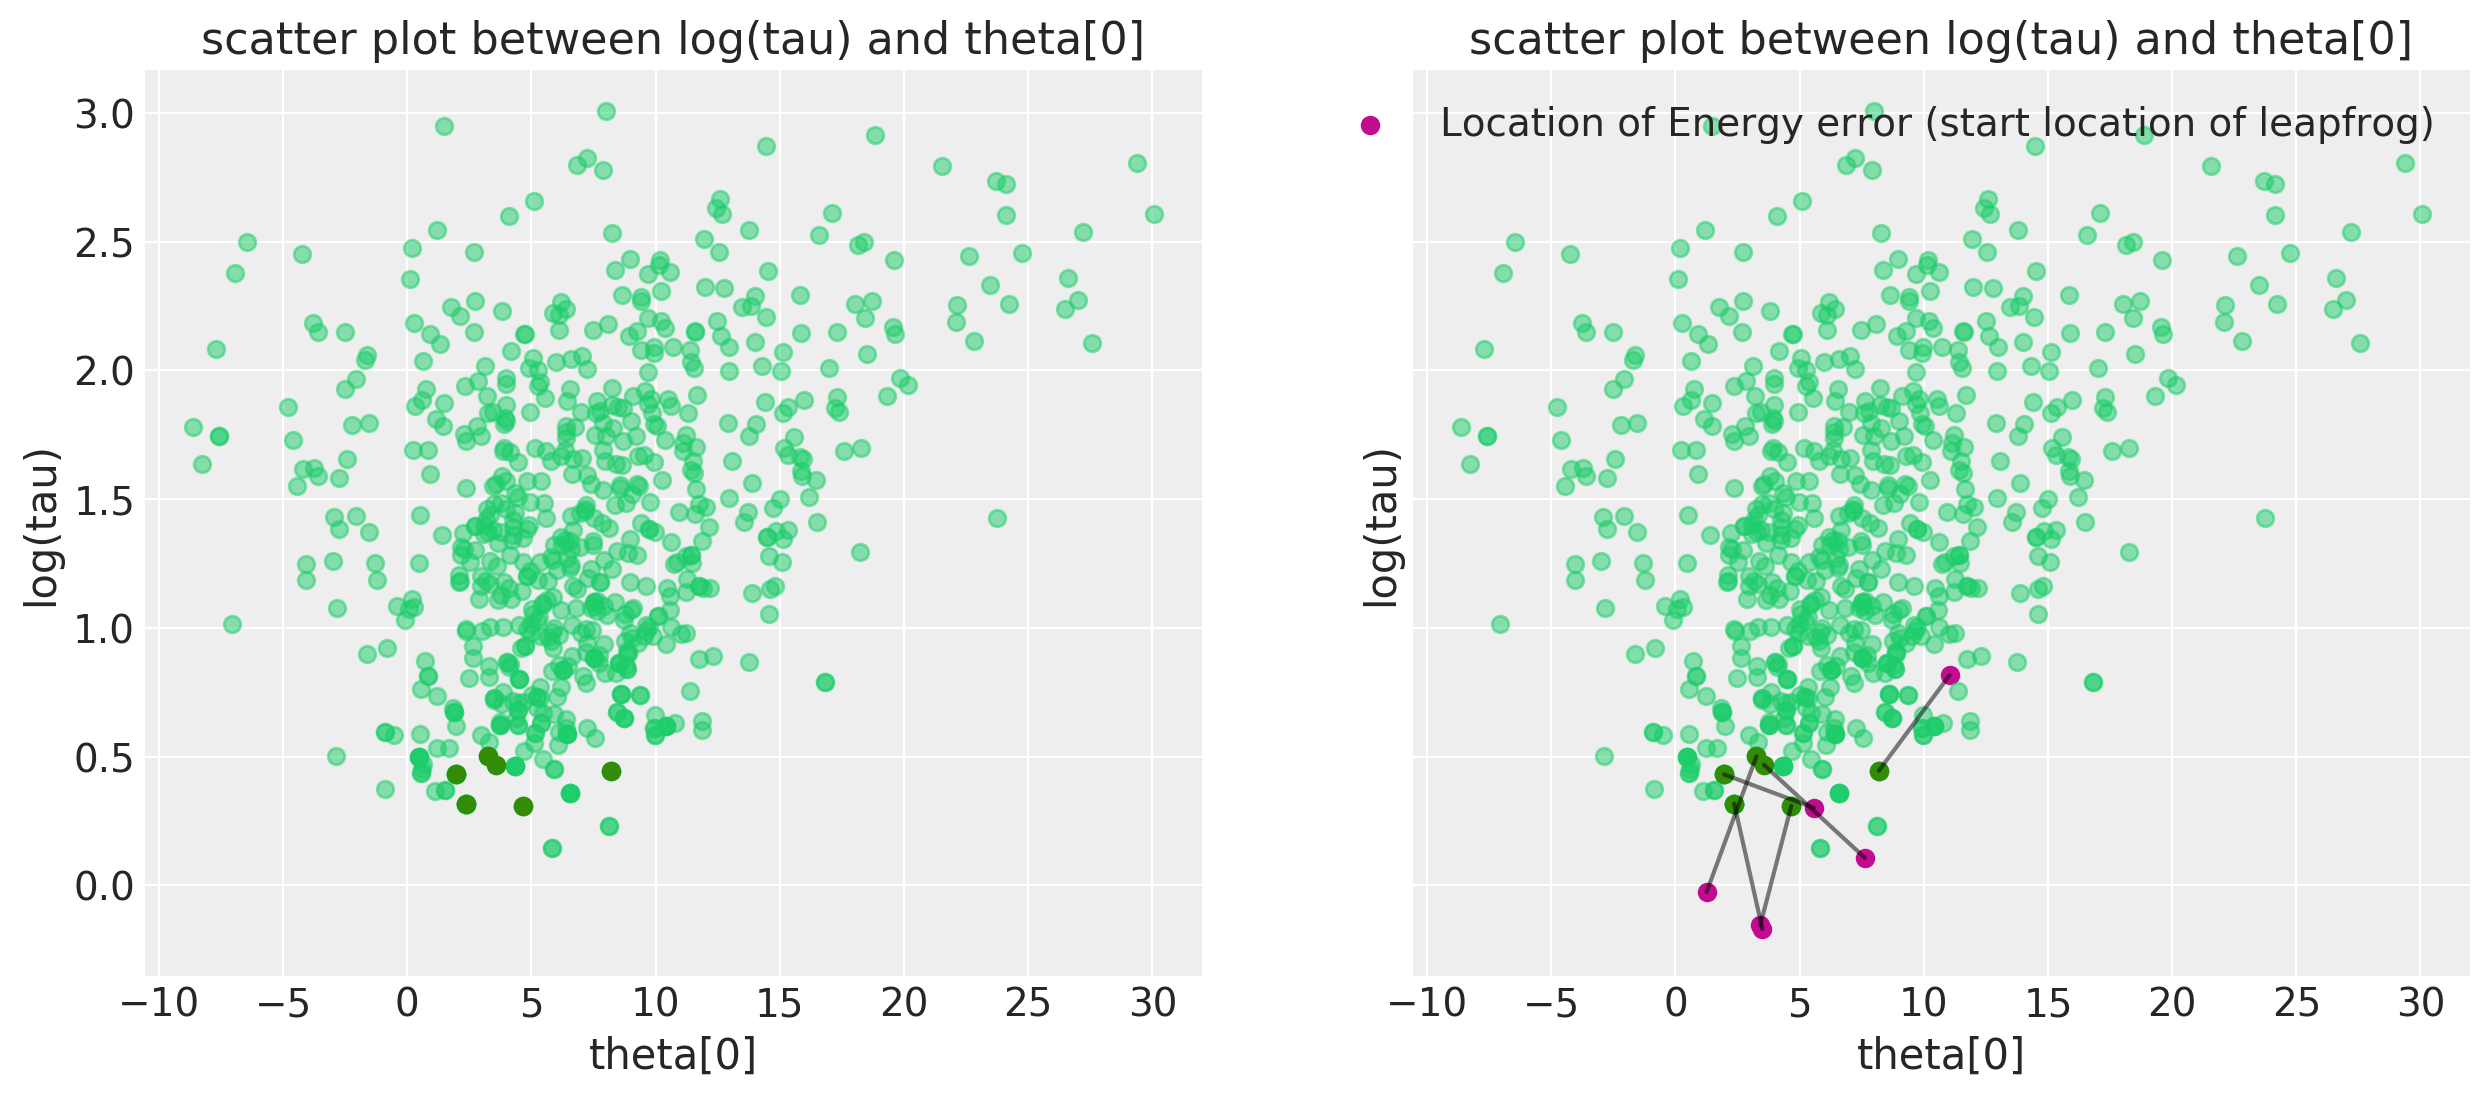

In [12]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

pairplot_divergence(short_trace, ax=ax[0], color='C7', divergence_color='C2')

plt.title('scatter plot between log(tau) and theta[0]')

pairplot_divergence(short_trace, ax=ax[1], color='C7', divergence_color='C2')

theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]

ax[1].plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.5)

ax[1].scatter(theta0_d, tau_log_d, 
              color='C3', 
              label='Location of Energy error (start location of leapfrog)')

plt.title('scatter plot between log(tau) and theta[0]')
plt.legend();

There are many other ways to explore and visualize the pathological region in the parameter space. For example, we can reproduce Figure 5b in [Visualization in Bayesian workflow](https://arxiv.org/pdf/1709.01449.pdf)

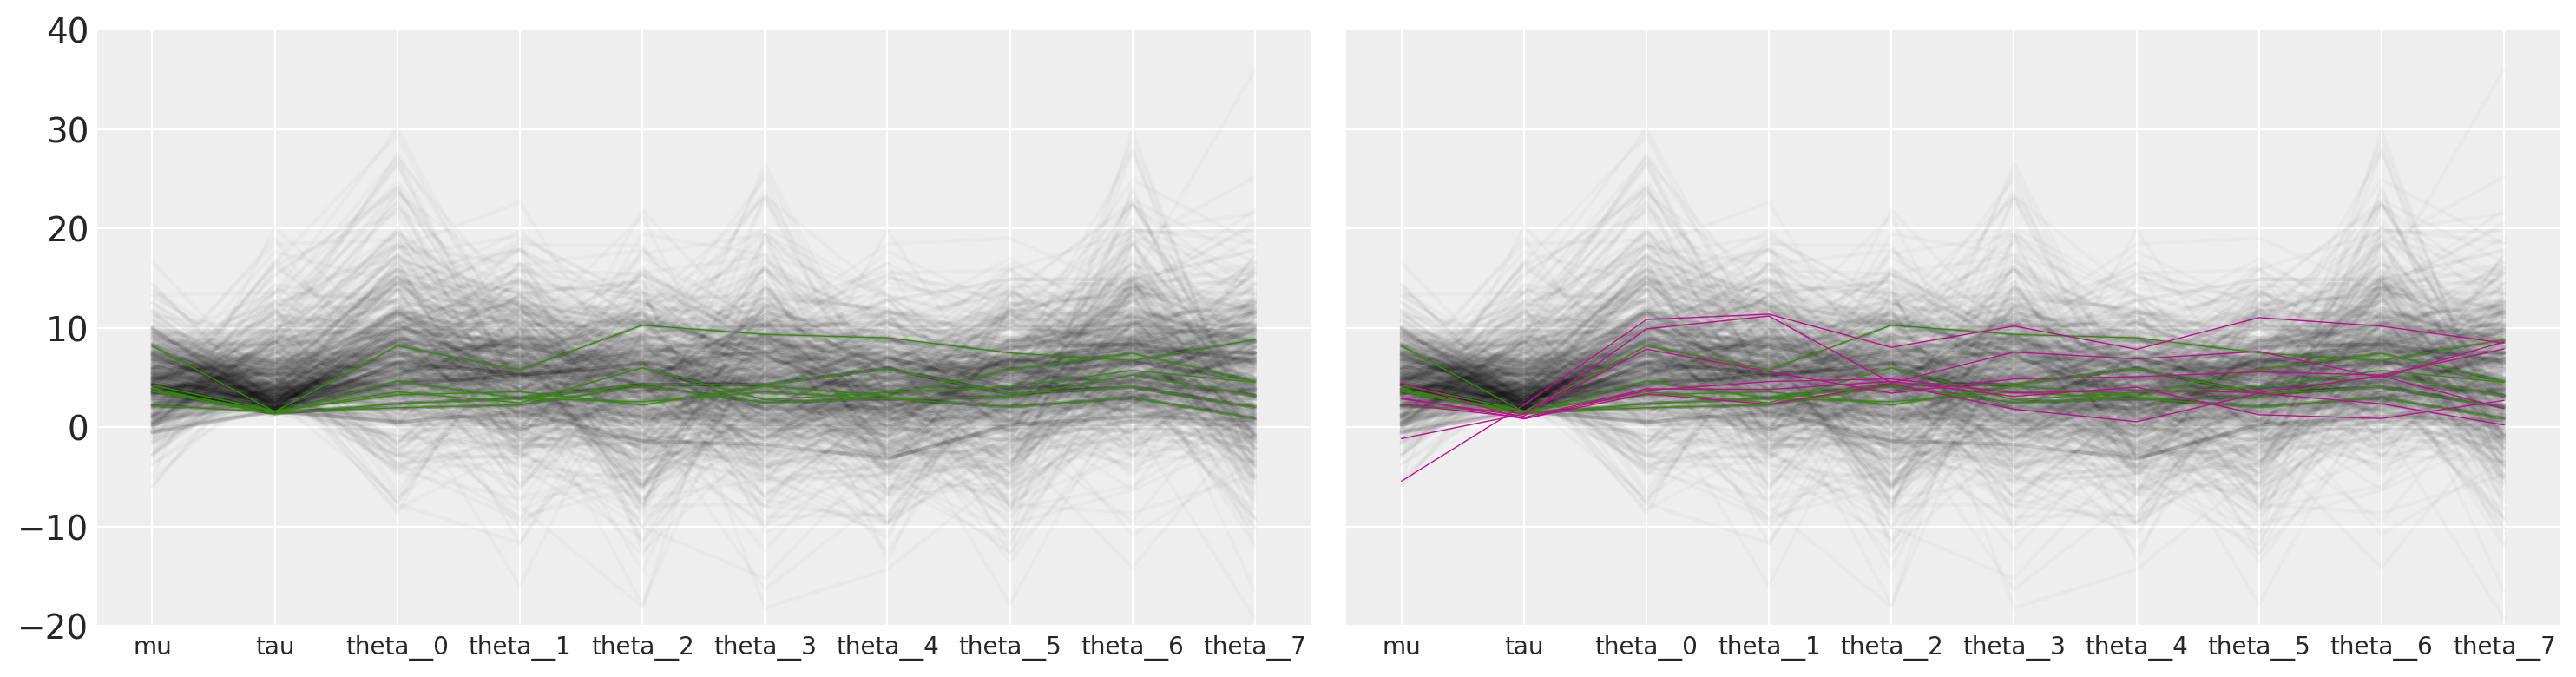

In [13]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
             'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
ax[0].xaxis.set_tick_params(labelsize=10)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
ax[1].xaxis.set_tick_params(labelsize=10)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
#ax[1].xaxis.set_tick_params(range(10), plotorder, labelsize=10)
plt.tight_layout();

In [14]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace):
    # plot the trace of log(tau)
    pm.traceplot({"log(tau)": trace.get_values(varname='tau_log__', combine=False)});
    
    # plot the estimate for the mean of log(τ) cumulating mean
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    plt.show()
    
    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)
    
    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace);

### A Safer, Longer Markov Chain  

The results above show why it is that the `Stan` team recommends always running multiple chains as long as possible to have the best chance to observe any obstructions to geometric ergodicity.  By examining the results of a longer run, we can see how more samples and more chains can show pathologies more clearly.  $\hat{R}$ still is not very helpful in finding the bad behavior, except for $\tau$, but the effective sample size definitely shows the issue.  Even more important, by exploring the state space more thoroughly, we encounter more divergences.

Looking at the trace plot for $log(\tau)$, we can see one of the chains getting stuck.

In [15]:
with Centered_eight:
    longer_trace = pm.sample(4000, chains=4, tune=1000, random_seed=SEED)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 10 seconds.
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6553297166531253, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6741257312258587, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
with Centered_eight:
    long_trace_summary = pm.summary(longer_trace).round(2)
    display(long_trace_summary)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu        4.65  3.24   -1.38    10.80       0.09     0.06    1283.0  1283.0   
theta[0]  6.60  5.61   -3.56    17.42       0.11     0.08    2582.0  2582.0   
theta[1]  5.26  4.66   -3.69    14.25       0.08     0.06    3292.0  3292.0   
theta[2]  4.28  5.29   -5.94    14.11       0.10     0.07    2732.0  2732.0   
theta[3]  5.01  4.83   -4.07    14.58       0.09     0.06    2981.0  2910.0   
theta[4]  3.88  4.69   -6.09    11.94       0.12     0.08    1639.0  1639.0   
theta[5]  4.23  4.84   -5.49    13.18       0.09     0.06    2984.0  2984.0   
theta[6]  6.67  5.09   -2.85    16.76       0.10     0.07    2541.0  2450.0   
theta[7]  5.11  5.41   -4.86    15.83       0.08     0.07    4270.0  3176.0   
tau       3.89  3.23    0.58     9.64       0.19     0.13     289.0   289.0   

          ess_bulk  ess_tail  r_hat  
mu          1227.0    1797.0   1.01  
theta[0]    2266.0    4860.0   1.02  
theta[1]    2721.0    5358.0   1.02  
theta[2]    2094.0    4969.0   1.01  
theta[3]    2470.0    5711.0   1.01  
theta[4]    1402.0    4587.0   1.01  
theta[5]    2508.0    5945.0   1.01  
theta[6]    2274.0    4646.0   1.02  
theta[7]    3092.0    5624.0   1.03  
tau           48.0      14.0   1.06

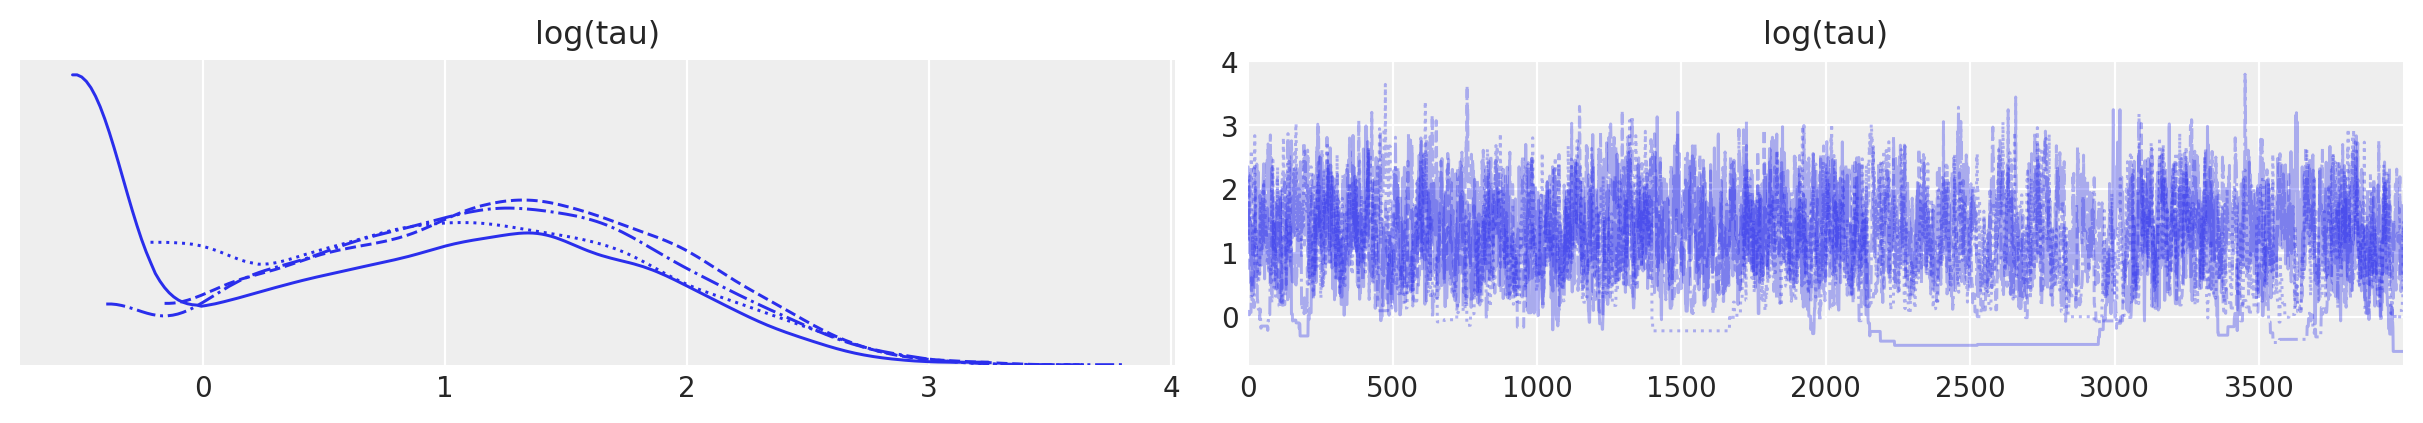

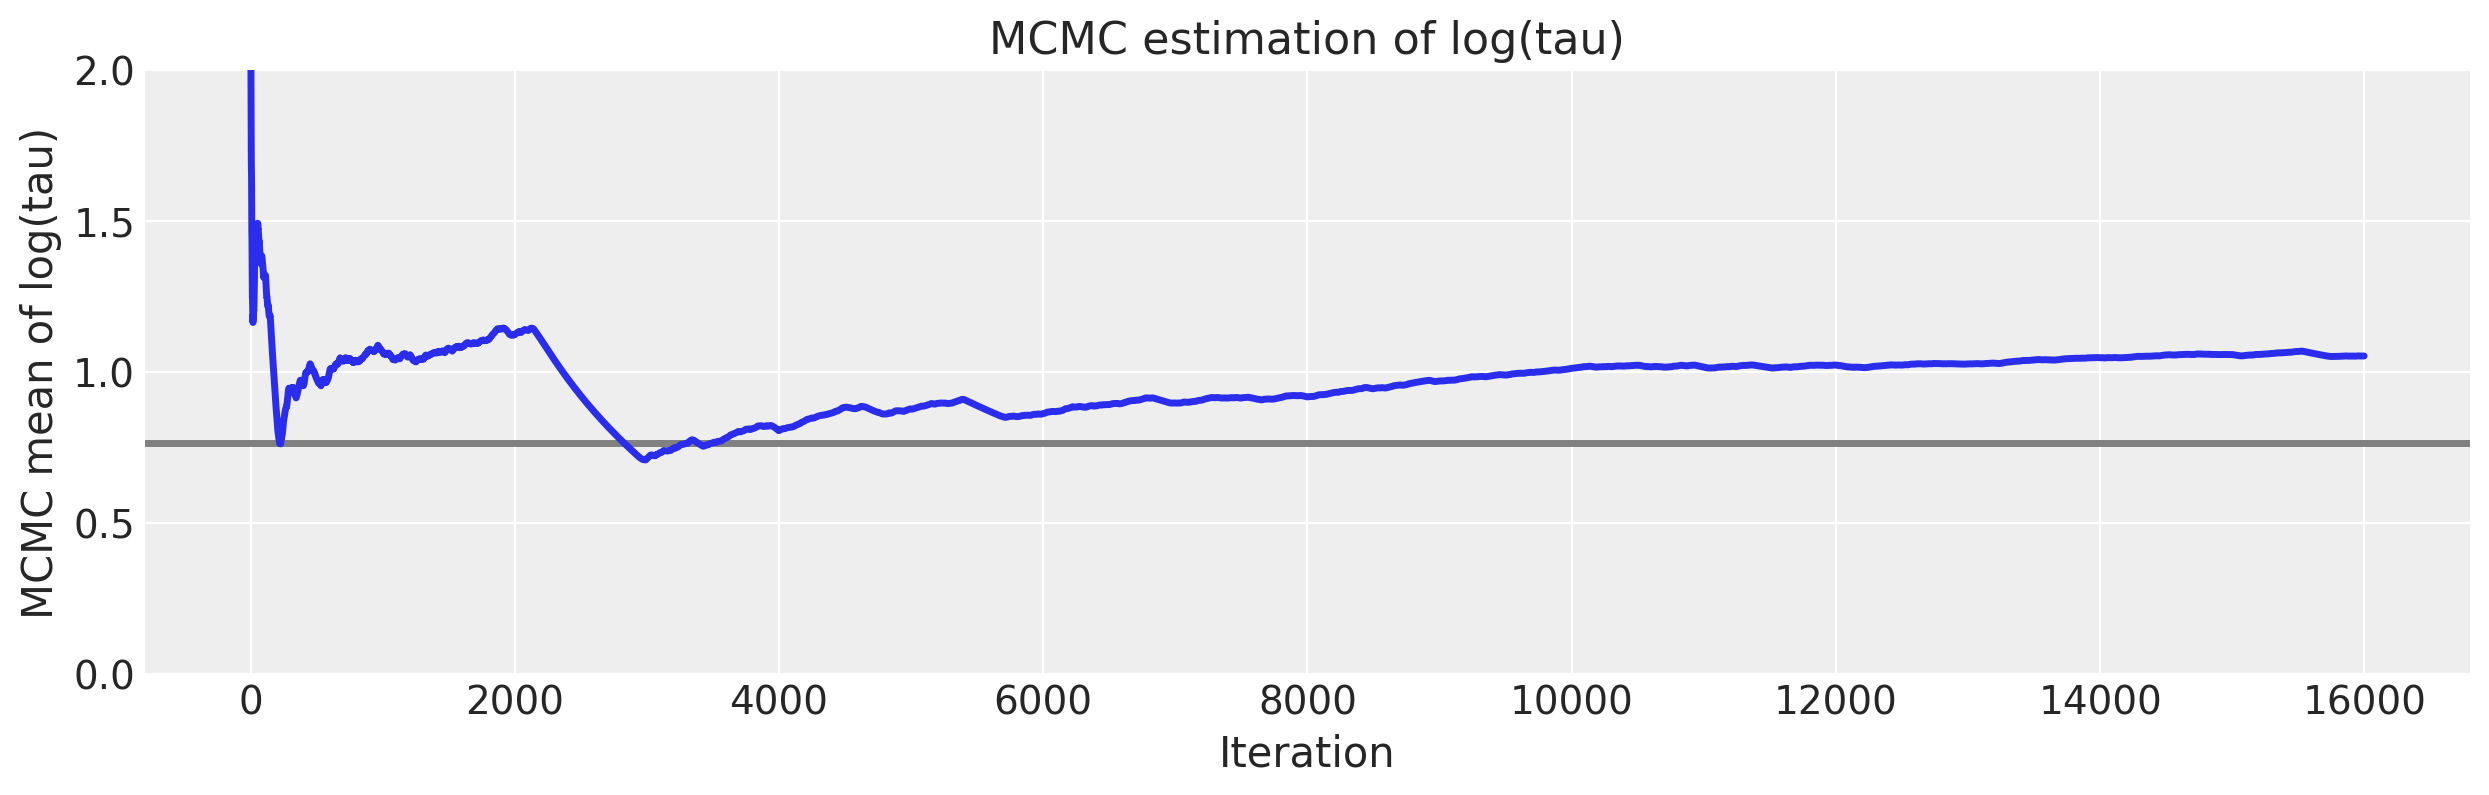

Number of Divergent 656
Percentage of Divergent 16.4


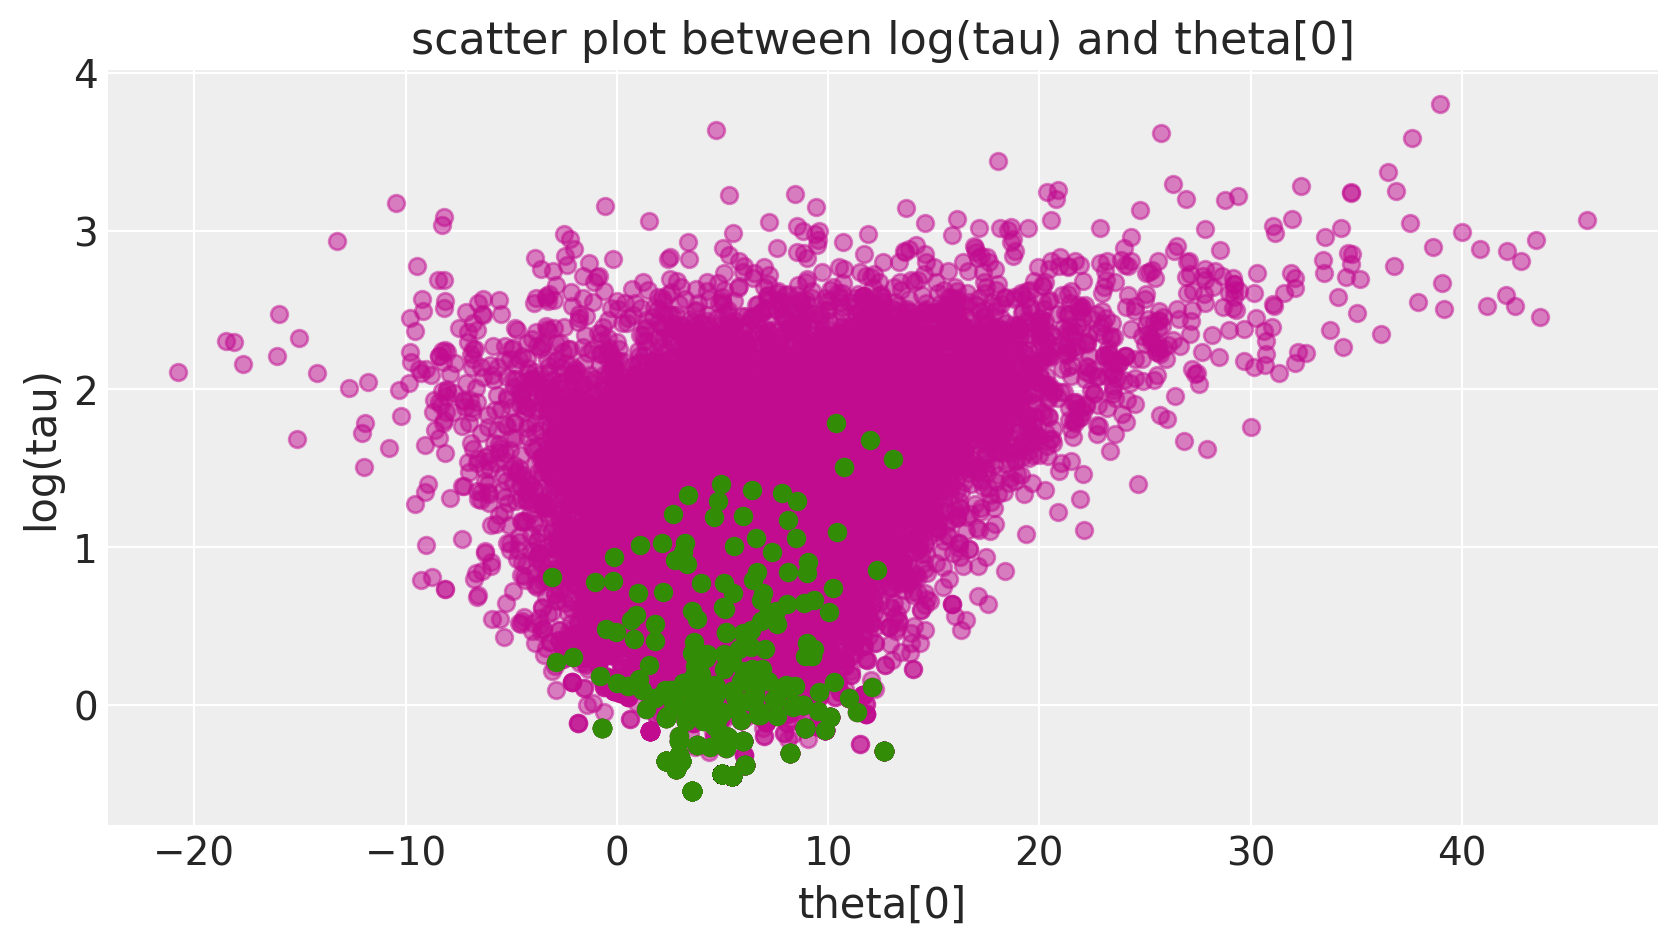

In [17]:
report_trace(longer_trace)

In [18]:
short = short_trace_summary.copy()
short["ess/it"] = (short['ess_mean'] / len(short_trace)).round(2)
short.columns = pd.MultiIndex.from_product([['short'], list(short.columns)])
long = long_trace_summary.copy()
long["ess/it"] = (long['ess_mean'] / len(longer_trace)).round(2)
long.columns = pd.MultiIndex.from_product([['long'], list(long.columns)])
pd.set_option('display.max_columns', None)
compare_frame = pd.concat([short, long], axis=1)
display(compare_frame)
display(compare_frame[[('short', 'r_hat'), ('long', 'r_hat'), ('short', 'ess/it'), ('long', 'ess/it')]])
#display(compare_frame[[['short', 'ess/it'], ['long', 'ess/it']]])

short                                                         \
          mean    sd hdi_3% hdi_97% mcse_mean mcse_sd ess_mean ess_sd   
mu        4.60  3.27  -1.63   10.13      0.32    0.22    108.0  107.0   
theta[0]  7.12  5.80  -3.78   18.70      0.42    0.30    194.0  194.0   
theta[1]  5.38  5.07  -4.04   15.05      0.33    0.24    242.0  227.0   
theta[2]  4.27  5.59  -6.07   15.51      0.37    0.26    233.0  233.0   
theta[3]  5.03  5.80  -5.40   16.92      0.31    0.29    352.0  195.0   
theta[4]  3.53  4.95  -5.26   13.38      0.41    0.29    147.0  147.0   
theta[5]  4.04  5.04  -5.88   13.89      0.35    0.25    206.0  206.0   
theta[6]  7.02  5.54  -2.86   18.44      0.38    0.27    210.0  210.0   
theta[7]  4.88  5.81  -5.14   16.39      0.38    0.28    238.0  216.0   
tau       4.74  3.23   1.16   10.76      0.46    0.33     49.0   49.0   

                                         long                                 \
         ess_bulk ess_tail r_hat ess/it  mean    sd hdi_3% hdi_97% mcse_mean   
mu          109.0    218.0  1.01   0.31  4.65  3.24  -1.38   10.80      0.09   
theta[0]    178.0    352.0  1.00   0.55  6.60  5.61  -3.56   17.42      0.11   
theta[1]    238.0    281.0  1.01   0.69  5.26  4.66  -3.69   14.25      0.08   
theta[2]    226.0    352.0  1.00   0.67  4.28  5.29  -5.94   14.11      0.10   
theta[3]    336.0    264.0  1.03   1.01  5.01  4.83  -4.07   14.58      0.09   
theta[4]    148.0    300.0  1.01   0.42  3.88  4.69  -6.09   11.94      0.12   
theta[5]    197.0    409.0  1.02   0.59  4.23  4.84  -5.49   13.18      0.09   
theta[6]    205.0    388.0  1.00   0.60  6.67  5.09  -2.85   16.76      0.10   
theta[7]    208.0    405.0  1.02   0.68  5.11  5.41  -4.86   15.83      0.08   
tau          39.0     49.0  1.05   0.14  3.89  3.23   0.58    9.64      0.19   

                                                                  
         mcse_sd ess_mean  ess_sd ess_bulk ess_tail r_hat ess/it  
mu          0.06   1283.0  1283.0   1227.0   1797.0  1.01   0.32  
theta[0]    0.08   2582.0  2582.0   2266.0   4860.0  1.02   0.65  
theta[1]    0.06   3292.0  3292.0   2721.0   5358.0  1.02   0.82  
theta[2]    0.07   2732.0  2732.0   2094.0   4969.0  1.01   0.68  
theta[3]    0.06   2981.0  2910.0   2470.0   5711.0  1.01   0.75  
theta[4]    0.08   1639.0  1639.0   1402.0   4587.0  1.01   0.41  
theta[5]    0.06   2984.0  2984.0   2508.0   5945.0  1.01   0.75  
theta[6]    0.07   2541.0  2450.0   2274.0   4646.0  1.02   0.64  
theta[7]    0.07   4270.0  3176.0   3092.0   5624.0  1.03   1.07  
tau         0.13    289.0   289.0     48.0     14.0  1.06   0.07

short  long  short   long
         r_hat r_hat ess/it ess/it
mu        1.01  1.01   0.31   0.32
theta[0]  1.00  1.02   0.55   0.65
theta[1]  1.01  1.02   0.69   0.82
theta[2]  1.00  1.01   0.67   0.68
theta[3]  1.03  1.01   1.01   0.75
theta[4]  1.01  1.01   0.42   0.41
theta[5]  1.02  1.01   0.59   0.75
theta[6]  1.00  1.02   0.60   0.64
theta[7]  1.02  1.03   0.68   1.07
tau       1.05  1.06   0.14   0.07

The effective sample size per iteration has drastically fallen, indicating that we are exploring less efficiently the longer we run. This odd behavior is a clear sign that something problematic is afoot. As shown in the trace plot, the chain occasionally "sticks" as it approaches small values of $\tau$, exactly where we saw the divergences concentrating. This is a clear indication of the underlying pathologies. These sticky intervals induce severe oscillations in the MCMC estimators early on, until they seem to finally settle into biased values.   

In fact the sticky intervals are the Markov chain trying to correct the biased exploration. If we ran the chain even longer then it would eventually get stuck again and drag the MCMC estimator down towards the true value. Given an infinite number of iterations this delicate balance asymptotes to the true expectation as we’d expect given the consistency guarantee of MCMC. Stopping after any finite number of iterations, however, destroys this balance and leaves us with a significant bias. 

More details can be found in Betancourt's [recent paper](https://arxiv.org/abs/1701.02434).  

## Mitigating Divergences by Adjusting PyMC3's Adaptation Routine

Divergences in Hamiltonian Monte Carlo arise when the Hamiltonian transition encounters regions of extremely large curvature, such as the opening of the hierarchical funnel. Unable to accurate resolve these regions, the transition malfunctions and flies off towards infinity. With the transitions unable to completely explore these regions of extreme curvature, we lose geometric ergodicity and our MCMC estimators become biased.

Algorithm implemented in `Stan` uses a heuristic to quickly identify these misbehaving trajectories, and hence label divergences, without having to wait for them to run all the way to infinity. This heuristic can be a bit aggressive, however, and sometimes label transitions as divergent even when we have not lost geometric ergodicity.

To resolve this potential ambiguity we can adjust the step size, $\epsilon$, of the Hamiltonian transition. The smaller the step size the more accurate the trajectory and the less likely it will be mislabeled as a divergence. In other words, if we have geometric ergodicity between the Hamiltonian transition and the target distribution then decreasing the step size will reduce and then ultimately remove the divergences entirely. If we do not have geometric ergodicity, however, then decreasing the step size will not completely remove the divergences.

Like `Stan`, the step size in `PyMC3` is tuned automatically during warm up, but we can coerce smaller step sizes by tweaking the configuration of `PyMC3`'s adaptation routine. In particular, we can increase the `target_accept` parameter from its default value of 0.8 closer to its maximum value of 1.

### Adjusting Adaptation Routine

In [19]:
with Centered_eight:
    fit_cp85 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 11 seconds.
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.590697710241605, but should be close to 0.85. Try to increase the number of tuning steps.
There were 751 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5543356020417641, but should be close to 0.85. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
with Centered_eight:
    fit_cp90 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 22 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8102746213078291, but should be close to 0.9. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8285553878814257, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
with Centered_eight:
    fit_cp95 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 49 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
with Centered_eight:
    fit_cp99 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 82 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [23]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                  fit_cp85['step_size'].mean(),
                  fit_cp90['step_size'].mean(),
                  fit_cp95['step_size'].mean(),
                  fit_cp99['step_size'].mean()], columns=['Step size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                            fit_cp85['diverging'].sum(),
                            fit_cp90['diverging'].sum(),
                            fit_cp95['diverging'].sum(),
                            fit_cp99['diverging'].sum()])
df['Target accept'] = pd.Series(['.80', '.85', '.90', '.95', '.99'])
df

Step size  Divergent Target accept
0   0.316584        656           .80
1   0.282771        985           .85
2   0.278982        268           .90
3   0.134916         80           .95
4   0.037769         24           .99

Here, the number of divergent transitions dropped dramatically when delta was increased to 0.99. 

This behavior also has a nice geometric intuition. The more we decrease the step size the more the Hamiltonian Markov chain can explore the neck of the funnel. Consequently, the marginal posterior distribution for $log (\tau)$ stretches further and further towards negative values with the decreasing step size. 

Since in `PyMC3` after tuning we have a smaller step size than `Stan`, the geometery is better explored.

However, the Hamiltonian transition is still not geometrically ergodic with respect to the centered implementation of the Eight Schools model. Indeed, this is expected given the observed bias.

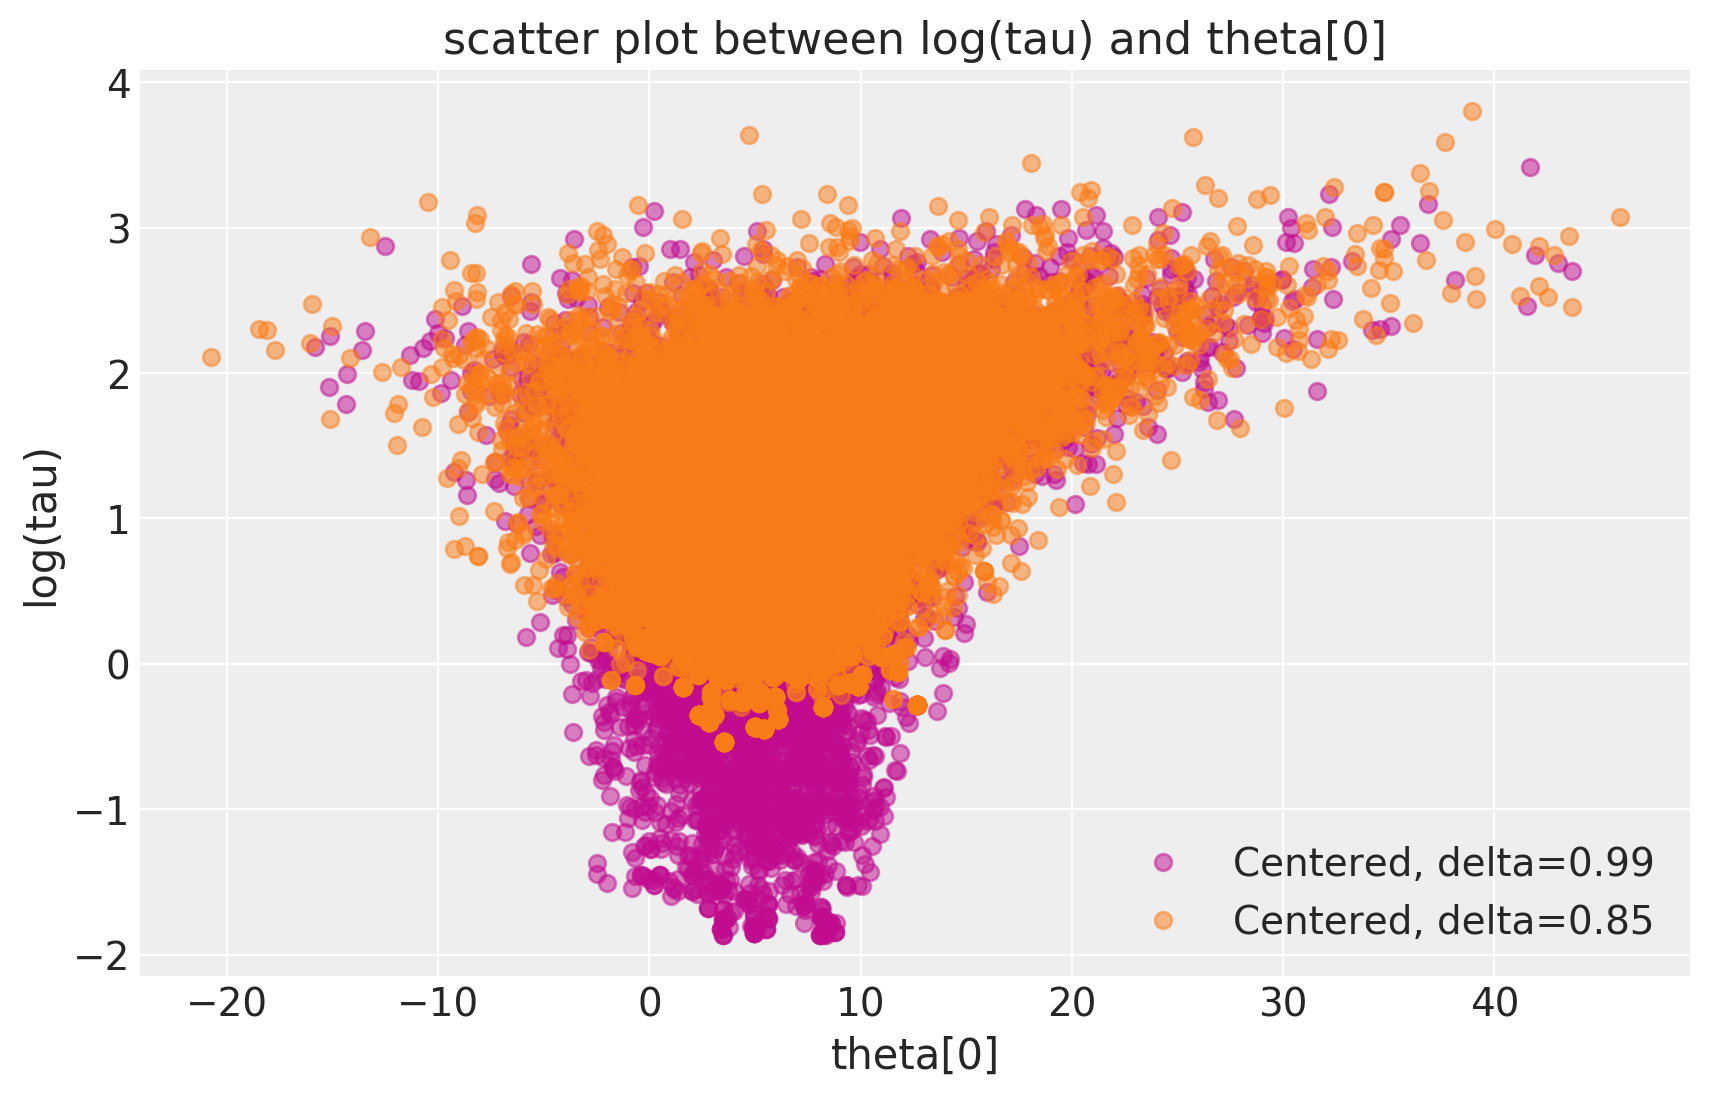

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pairplot_divergence(fit_cp99, ax=ax, color='C3', divergence=False)

pairplot_divergence(longer_trace, ax=ax, color='C1', divergence=False)

ax.legend(['Centered, delta=0.99', 'Centered, delta=0.85']);

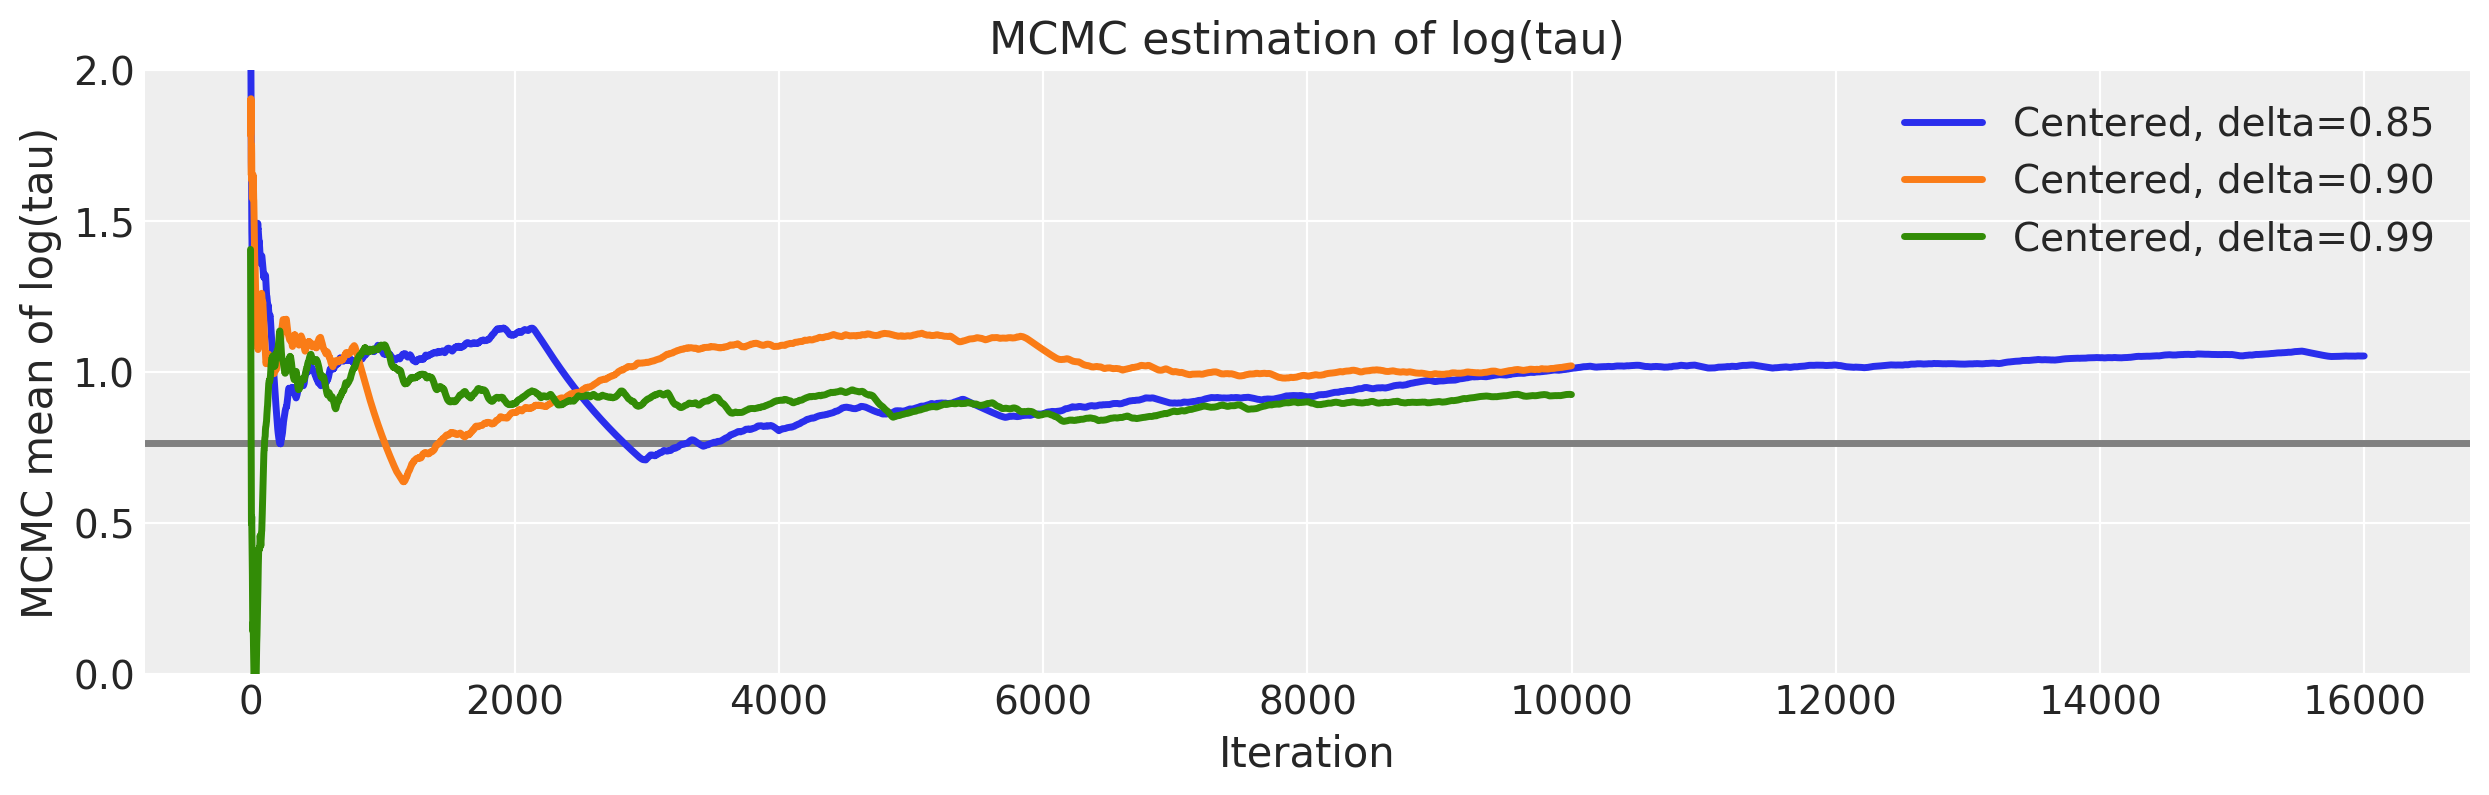

In [25]:
logtau0 = longer_trace['tau_log__']
logtau2 = np.log(fit_cp90['tau'])
logtau1 = fit_cp99['tau_log__']

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.85', lw=2.5)
mlogtau2 = [np.mean(logtau2[:i]) for i in np.arange(1, len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90', lw=2.5)
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99', lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();

## A Non-Centered Eight Schools Implementation  
 
Although reducing the step size improves exploration, ultimately it only reveals the true extent the pathology in the centered implementation. Fortunately, there is another way to implement hierarchical models that does not suffer from the same pathologies.  

In a non-centered parameterization we do not try to fit the group-level parameters directly, rather we fit a latent Gaussian variable from which we can recover the group-level parameters with a scaling and a translation.  

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\tilde{\theta}_{n} \sim \mathcal{N}(0, 1)$$
$$\theta_{n} = \mu + \tau \cdot \tilde{\theta}_{n}.$$

Stan model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
```

In [26]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

In [27]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(5000, chains=4, tune=1000, random_seed=SEED,
                         target_accept=.80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.


In [28]:
with NonCentered_eight:
    non_centered_summary = pm.summary(fit_ncp80)
non_centered_summary['ess/it'] = (non_centered_summary['ess_mean'] / len(fit_ncp80))

non_centered_summary.round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu          4.40  3.28   -2.16    10.24       0.03     0.02   14842.0   
theta_t[0]  0.30  0.99   -1.58     2.13       0.01     0.01   16133.0   
theta_t[1]  0.10  0.94   -1.63     1.89       0.01     0.01   17452.0   
theta_t[2] -0.08  0.99   -1.95     1.78       0.01     0.01   18386.0   
theta_t[3]  0.06  0.94   -1.73     1.80       0.01     0.01   18062.0   
theta_t[4] -0.17  0.93   -1.90     1.62       0.01     0.01   17626.0   
theta_t[5] -0.07  0.93   -1.80     1.70       0.01     0.01   18403.0   
theta_t[6]  0.36  0.96   -1.37     2.20       0.01     0.01   17162.0   
theta_t[7]  0.08  0.96   -1.75     1.86       0.01     0.01   18416.0   
tau         3.60  3.21    0.00     9.26       0.03     0.03    9269.0   
theta[0]    6.15  5.46   -3.64    16.66       0.05     0.04   13832.0   
theta[1]    4.94  4.65   -3.92    13.79       0.04     0.03   16519.0   
theta[2]    3.95  5.27   -5.96    14.22       0.04     0.03   13502.0   
theta[3]    4.78  4.75   -4.32    13.77       0.04     0.03   16825.0   
theta[4]    3.59  4.66   -5.92    11.77       0.04     0.03   14832.0   
theta[5]    4.10  4.72   -4.75    13.42       0.04     0.03   15826.0   
theta[6]    6.32  5.07   -2.94    16.15       0.04     0.03   14041.0   
theta[7]    4.88  5.25   -5.06    15.03       0.04     0.04   13664.0   

             ess_sd  ess_bulk  ess_tail  r_hat  ess/it  
mu          14362.0   14924.0   10603.0    1.0    2.97  
theta_t[0]   8256.0   16028.0   10543.0    1.0    3.23  
theta_t[1]   8668.0   17507.0   12643.0    1.0    3.49  
theta_t[2]   7045.0   18361.0   11549.0    1.0    3.68  
theta_t[3]   7808.0   18076.0   12028.0    1.0    3.61  
theta_t[4]   9186.0   17638.0   12763.0    1.0    3.53  
theta_t[5]   8780.0   18411.0   13505.0    1.0    3.68  
theta_t[6]   9642.0   17096.0   12606.0    1.0    3.43  
theta_t[7]   8248.0   18394.0   12620.0    1.0    3.68  
tau          7021.0    9218.0    8650.0    1.0    1.85  
theta[0]    10976.0   15317.0   11102.0    1.0    2.77  
theta[1]    14424.0   16845.0   12935.0    1.0    3.30  
theta[2]    11984.0   14307.0   10961.0    1.0    2.70  
theta[3]    13019.0   17449.0   13228.0    1.0    3.36  
theta[4]    13626.0   15557.0   12035.0    1.0    2.97  
theta[5]    12971.0   16233.0   11311.0    1.0    3.17  
theta[6]    11097.0   14857.0   12450.0    1.0    2.81  
theta[7]    10037.0   14571.0   11810.0    1.0    2.73

As shown above, the effective sample size per iteration (`ess/it`) has drastically improved, and the trace plots no longer show any "stickyness". However, we do still see the rare divergence. These infrequent divergences do not seem concentrate anywhere in parameter space, which is indicative of the divergences being false positives.

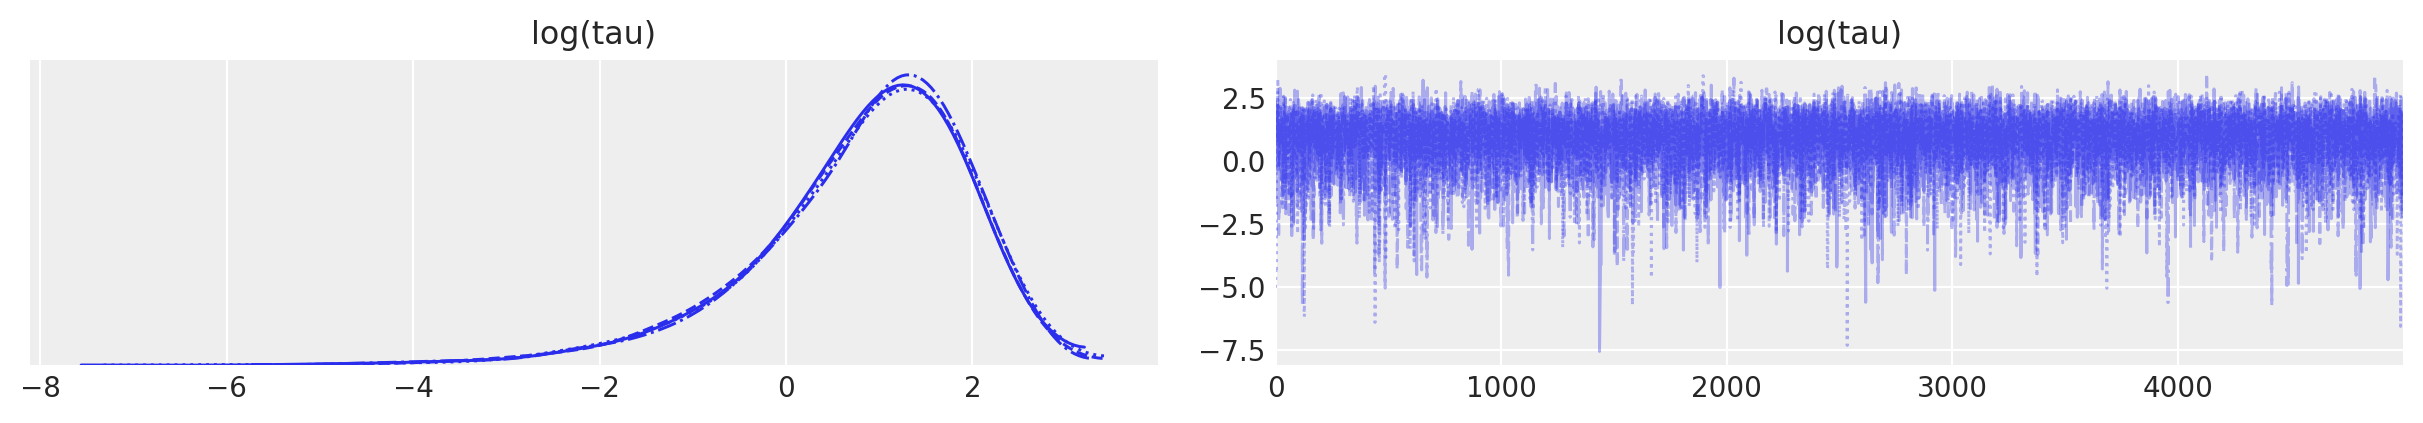

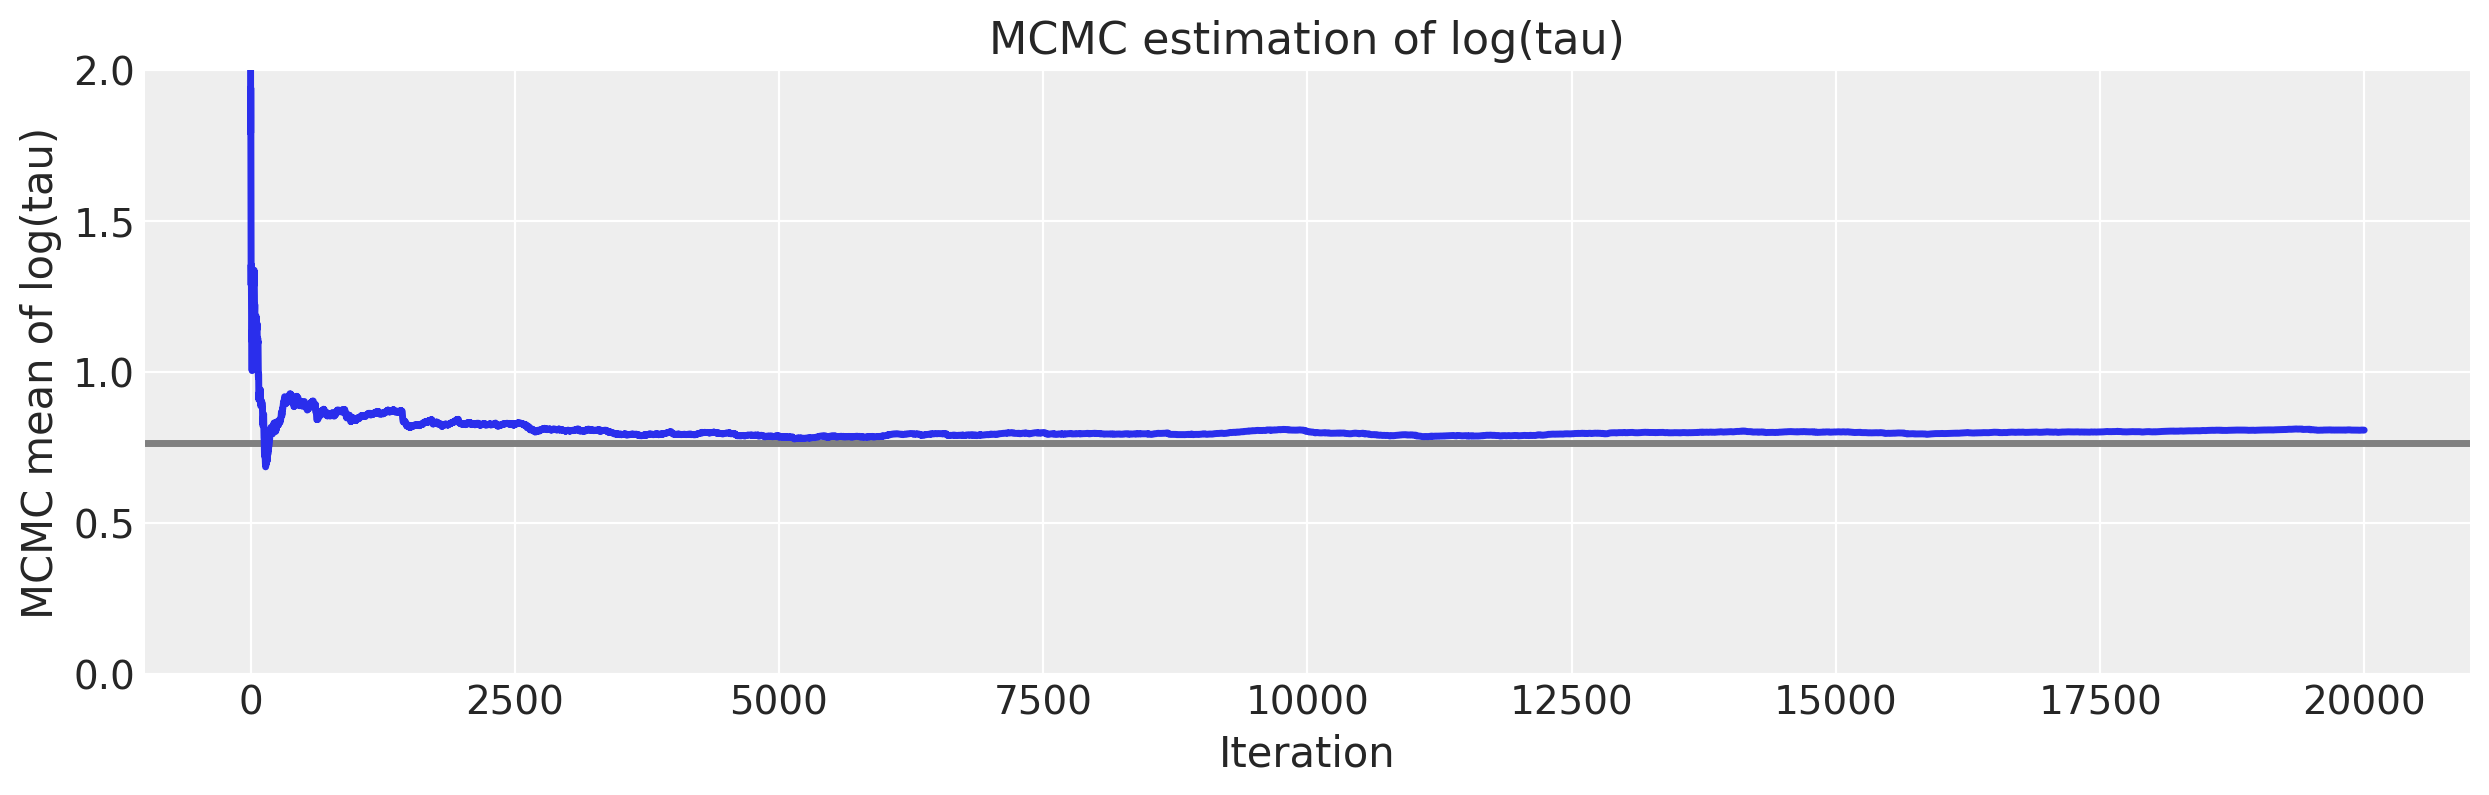

Number of Divergent 261
Percentage of Divergent 5.2


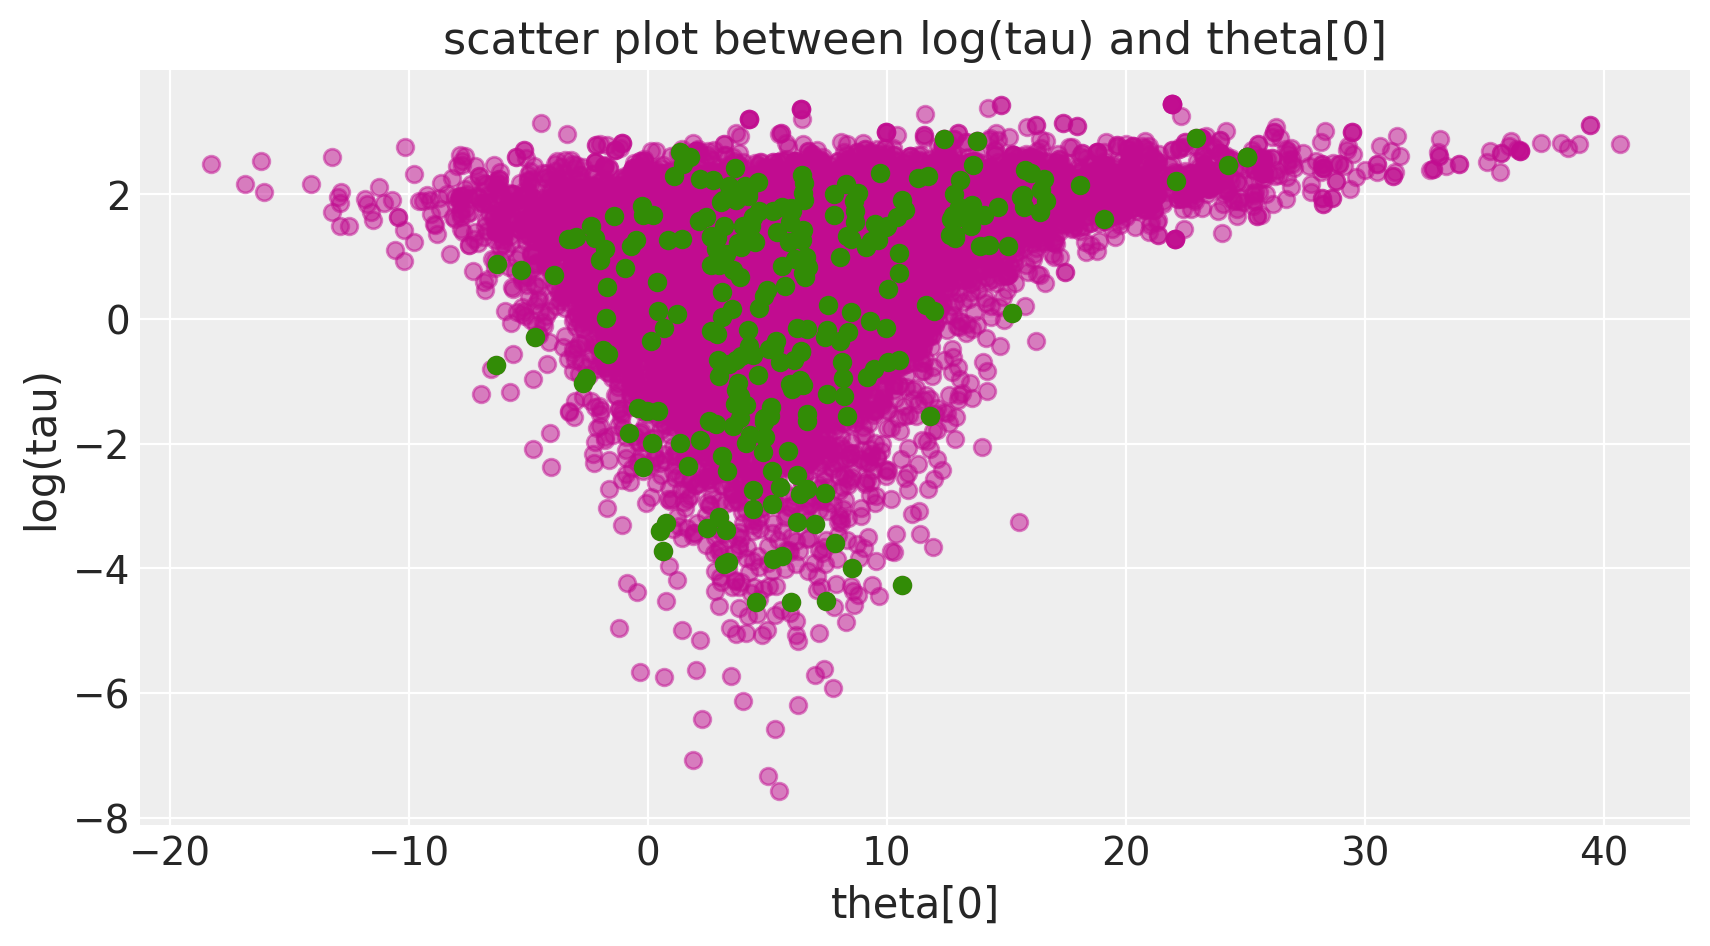

In [29]:
report_trace(fit_ncp80)

As expected of false positives, we can remove the divergences entirely by decreasing the step size,

In [30]:
with NonCentered_eight:
    fit_ncp90 = pm.sample(5000, chains=4, tune=1000, random_seed=SEED,
                         target_accept=.90)
    
# display the total number and percentage of divergent
divergent = fit_ncp90['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Number of Divergent 2


The more agreeable geometry of the non-centered implementation allows the Markov chain to explore deep into the neck of the funnel, capturing even the smallest values of $\tau$ that are consistent with the measurements. Consequently, MCMC estimators from the non-centered chain rapidly converge towards their true expectation values.

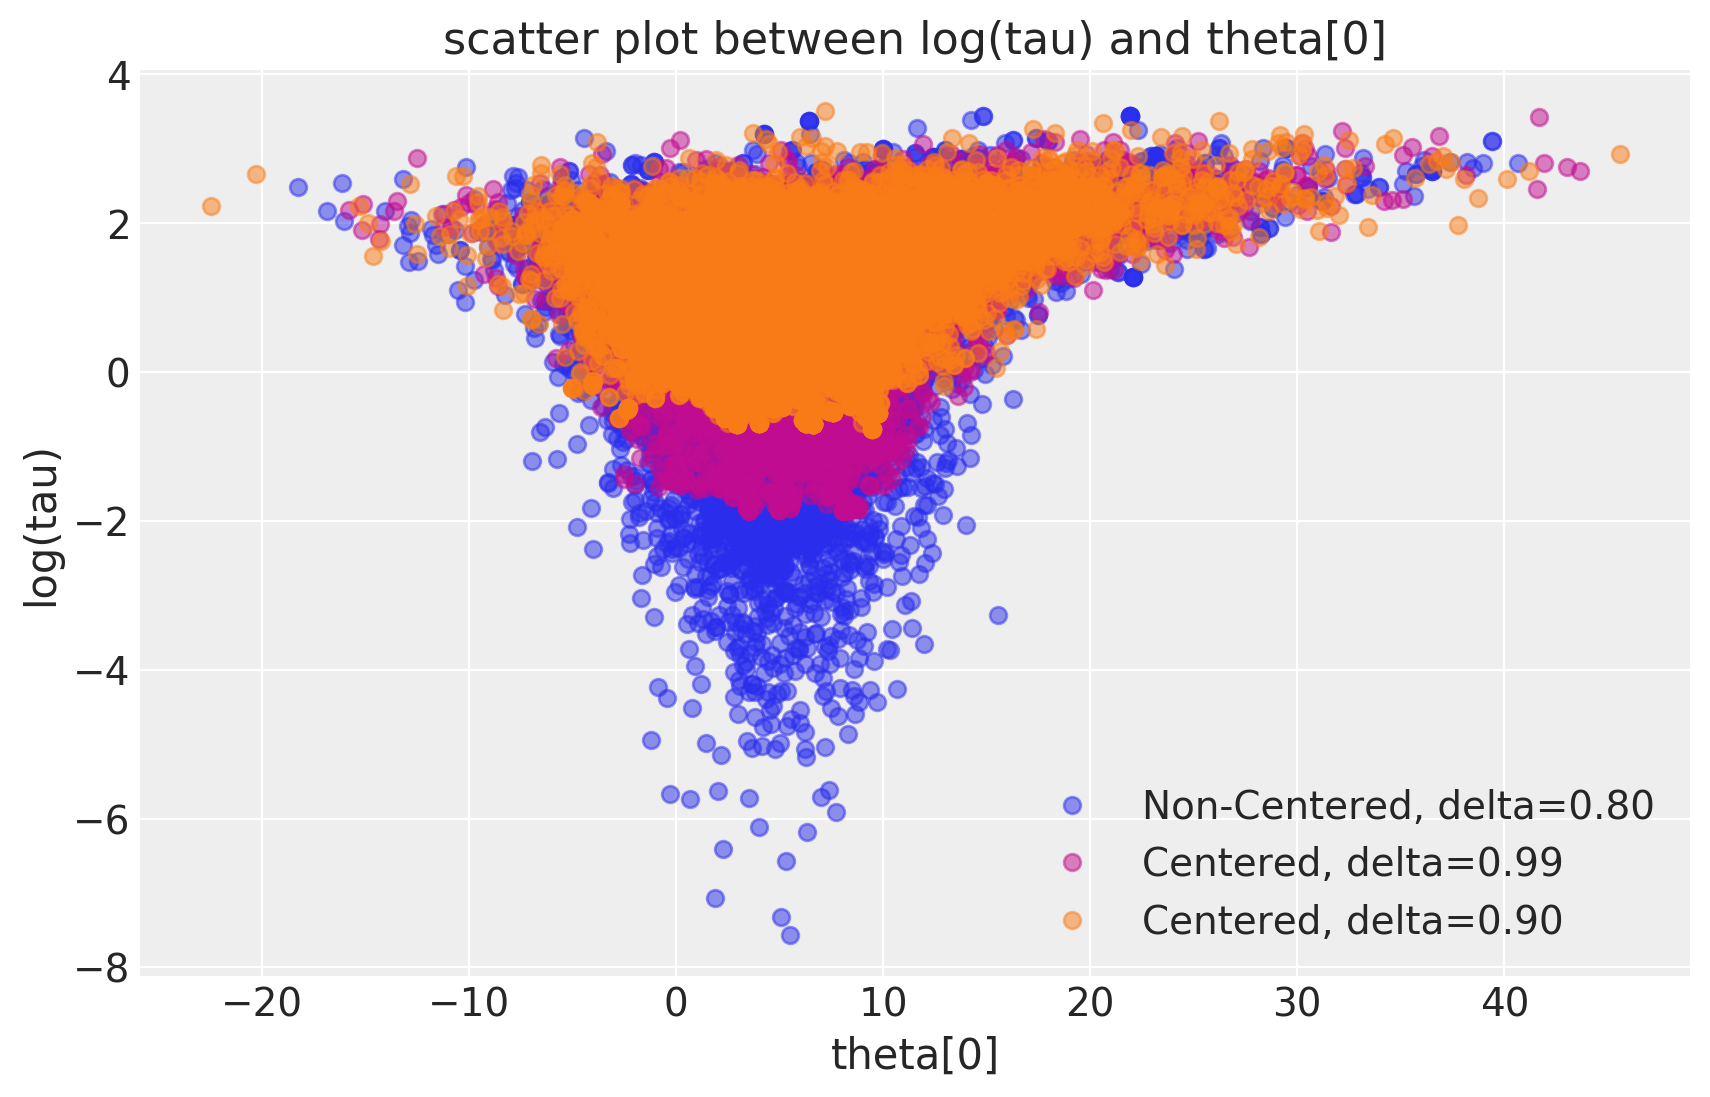

In [31]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pairplot_divergence(fit_ncp80, ax=ax, color='C0', divergence=False)
pairplot_divergence(fit_cp99, ax=ax, color='C3', divergence=False)
pairplot_divergence(fit_cp90, ax=ax, color='C1', divergence=False)

ax.legend(['Non-Centered, delta=0.80', 'Centered, delta=0.99', 'Centered, delta=0.90']);

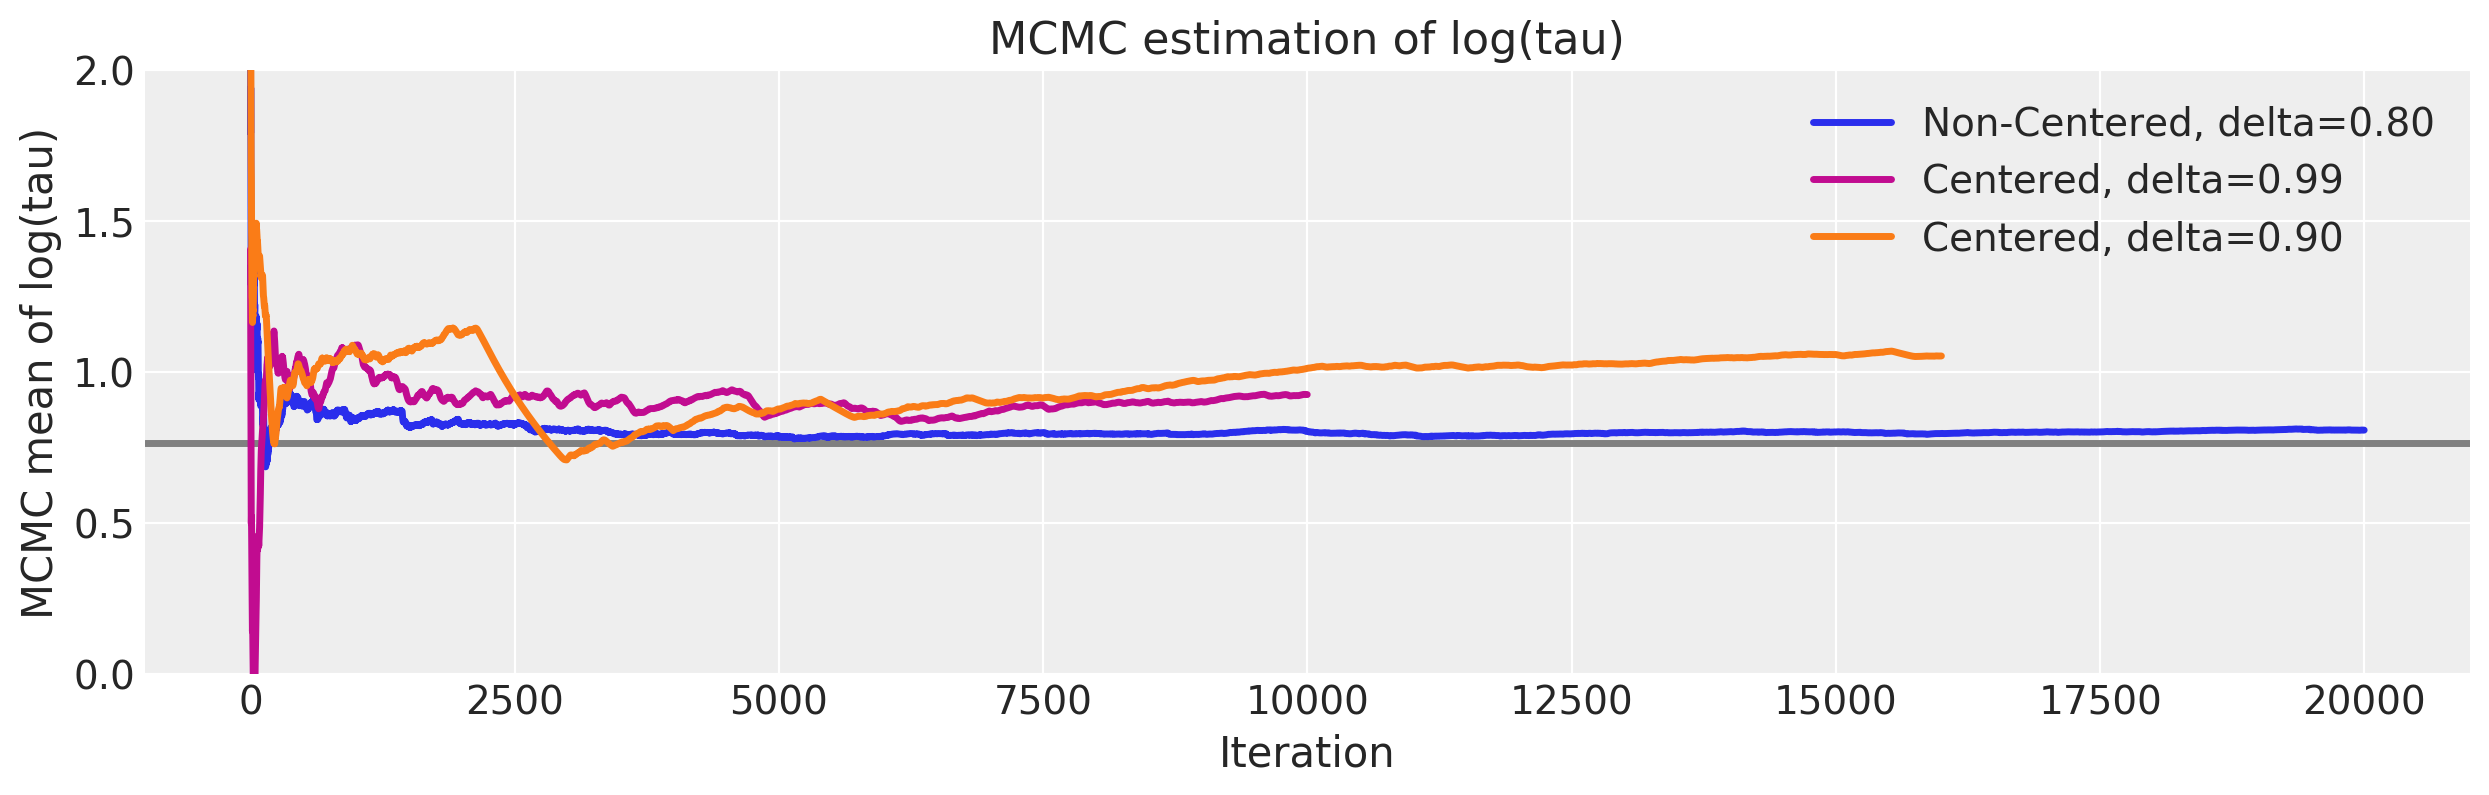

In [32]:
logtaun = fit_ncp80['tau_log__']

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun, color='C0', lw=2.5, label='Non-Centered, delta=0.80')

mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, color='C3', lw=2.5, label='Centered, delta=0.99')

mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, color='C1', lw=2.5, label='Centered, delta=0.90')
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3  3.9.1
pandas 1.0.1
arviz  0.8.3
numpy  1.18.1
last updated: Thu Jun 18 2020 

CPython 3.6.8
IPython 7.12.0
watermark 2.0.2
